# Example: mesh a delineated watershed

Here we mesh the Coal Creek Watershed, CO as an example of how to pull data in from default locations and generate a fully functional ATS mesh.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys,yaml
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
# from matplotlib_scalebar.scalebar import ScaleBar
import shapely
import logging
import pandas
import datetime
pandas.options.display.max_columns = None


import watershed_workflow
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.colors
import watershed_workflow.condition
import watershed_workflow.mesh
import watershed_workflow.split_hucs
import watershed_workflow.land_cover_properties

watershed_workflow.ui.setup_logging(1,None)
figsize = (6,6)
figsize_3d = (8,6)


In [3]:
import h5py
from modvis import ATSutils

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS (in UTM coordinates) that is included in the shapefile. 

<span style="color:blue;">If the CRS is in lat-lon (in degrees), convert it to UTM (in meters).</span>


In [4]:
# specify the input shapefile and a hint as to what HUC it is in.
watershed_name = 'CoalCreek'
watershed_shapefile = f'../../data/examples/{watershed_name}/sources/shapefile/CoalCreek.shp'

#====== optional local files ======#
# These files are optional if you prefer WW to download these for you, which may take a long time...
# see the following Source section for manual download
watershed_landcover = f'../../data/examples/{watershed_name}/sources/land_cover/NLCD/CoalCreek_nlcd2016.tif'
watershed_glhymps = f'../../data/examples/{watershed_name}/sources/GLHYMPS/CoalCreek_glhymps_v2.shp'
watershed_dtb = f'../../data/examples/{watershed_name}/sources/DTB/CoalCreek_dtb.tif'
watershed_modis_lulc = f'../../data/examples/{watershed_name}/sources/land_cover/MODIS/MCD12Q1.006_500m_aid0001.nc'
watershed_modis_lai = f'../../data/examples/{watershed_name}/sources/land_cover/MODIS/MCD15A3H.006_500m_aid0001.nc'

config = {} # this will store all the filenames used in input file
config_fname = f'../../data/examples/{watershed_name}/processed/config.yaml'

hint = '1402'  # hint: HUC 4 containing this shape.  
               # This is necessary to avoid downloading all HUCs to search for this shape
huc = "140200010204" # provide the huc code for that watershed. If `None`, the script will automatically search for the HUC code.
simplify = 30 # length scale to target average edge, same unit as the watershed CRS

# start and end of simulation -- one year of simulation that is in both the MODIS and DayMet dataset ranges
start_date = "2015-10-1"
end_date = "2016-10-1"
# origin of simulation. By default, use the first available date of Daymet forcing. 
# This is necessary to ensure that all datesets use the same origin date.
origin_date = "1980-1-1"

logging.info("")
logging.info("Meshing shape: {}".format(watershed_shapefile))
logging.info("="*30)

# get the shape and crs of the shape
crs, watershed = watershed_workflow.get_split_form_shapes(watershed_shapefile)

2023-07-19 19:11:21,257 - root - INFO: 
2023-07-19 19:11:21,261 - root - INFO: Meshing shape: ../../data/examples/CoalCreek/sources/shapefile/CoalCreek.shp
2023-07-19 19:11:21,265 - root - INFO: ==============================
2023-07-19 19:11:21,272 - root - INFO: 
2023-07-19 19:11:21,276 - root - INFO: Loading shapes
2023-07-19 19:11:21,279 - root - INFO: ------------------------------
2023-07-19 19:11:21,282 - root - INFO: Loading file: '../../data/examples/CoalCreek/sources/shapefile/CoalCreek.shp'
2023-07-19 19:11:21,461 - root - INFO: ... found 1 shapes
2023-07-19 19:11:21,466 - root - INFO: Converting to shapely


### Sources

A wide range of data sources are available and shown below:

| source | File_Manager | Options|
|:---:|:---:|:---:|
|sources['DEM']| `FileManagerNED()` | `1 arc-second` (*); `1/3 arc-second`|
|sources['HUC']| `FileManagerNHD()` | `NHDPlus` (*); `NHD`; `WBD`|
|sources['hydrography']| `FileManagerNHD()` | `NHDPlus` (*); `NHD`|
|sources['land cover']| `FileManagerNLCD()` | `NLCD (L48)` (*); `NLCD (AK)`; `MODIS`|
|sources['geologic structure']| `FileManagerGLHYMPS()` | `GLHYMPS` (*)|
|sources['soil structure']| `FileManagerNRCS()` | `NRCS SSURGO` (*)|
|sources['DTB']| `FileManagerSoilGrids2017()` | `SoilGrids2017` (*)|
|sources['lai']| `FileManagerMODISAppEEARS()` | `MODIS` (*)|
|sources['meteorology']| `FileManagerDaymet()` | `DayMet` (*)|

Note, custom sources can be imported using:

```python
# if raster
sources['SOURCE NAME'] = watershed_workflow.source_list.FileManagerRaster('PATH/TO/RASTER')

# for example
sources['depth to bedrock'] = watershed_workflow.source_list.FileManagerRaster('./Global_absoluteDTB_M_250m_ll.tif')
```

By default, Watershed-Workflow (WW) will place all the downloads in a folder named `data_library` or the mounted data volume and has the following structure (generated by WW):

```bash
.
├── dem
│   ├── 13as_raw
│   └── 1as_raw
├── hydrography
├── land_cover
│   ├── MODIS
│   ├── NLCD_2016_Land_Cover_L48
│   └── NLCD_2019_Land_Cover_L48
├── meteorology
│   └── daymet
└── soil_structure
    ├── GLHYMPS
    ├── SSURGO
    ├── SoilGrids2017
    └── depth-to-bedrock
```

Some of the sources do not have API and may need to be downloaded manually. Here are a list of sources to download:

| source | Download Link| Local Path| Notes|
|:---:|:---:|:---:|:---:|
| GLHYMPS v2  | [Download link](https://doi.org/10.5683/SP2/TTJNIU) | `data/soil_structure/GLHYMPS`| ~2.4 GB. Unzip the .zip file and place all the files under the path|
| Depth-to-bedrock (~2.4 GB) | [Download link](http://globalchange.bnu.edu.cn/research/dtb.jsp) | `data/soil_structure/depth-to-bedrock`| ~10 GB. Look for file named `Global_absoluteDTB_M_250m_ll.tif` (250 m resolution). This file is slightly different from the data found in [SoilGrids](https://soilgrids.org/). Why?|
|NLCD landcover| [Download link](https://www.sciencebase.gov/catalog/item/604a4fb1d34eb120311b0039)| `data/land_cover/NLCD_YEAR_Land_Cover_L48`|~2.2 GB. The Year 2016 product is used in this example, but feel free to use the most recent product|
|MODIS|See [LAI](#lai) section on how to download MODIS product manually| `data/land_cover/MODIS`| You will need an [AppEEARS](https://appeears.earthdatacloud.nasa.gov/) account to download files|

In [5]:
# set up a dictionary of source objects
sources = watershed_workflow.source_list.get_default_sources()
# sources['depth to bedrock'] = watershed_workflow.source_list.FileManagerSoilGrids2017()

#
# This demo uses a few datasets that have been clipped out of larger, national
# datasets and are distributed with the code.  This is simply to save download
# time for this simple problem and to lower the barrier for trying out
# Watershed Workflow.  A more typical workflow would delete these lines (as 
# these files would not exist for other watersheds).
#
# The default versions of these download large raster and shapefile files that
# are defined over a very large region (globally or the entire US).
#
# Note we also prepopulate some data for MODIS data as well.
#
sources['land cover'] = watershed_workflow.source_list.FileManagerRaster(watershed_landcover)
sources['geologic structure'] = watershed_workflow.source_list.FileManagerGLHYMPS(watershed_glhymps)
sources['depth to bedrock'] = watershed_workflow.source_list.FileManagerRaster(watershed_dtb)
# sources['MODIS LULC'] = watershed_workflow.source_list.FileManagerRaster(watershed_modis_lulc)

watershed_workflow.source_list.log_sources(sources)

2023-07-19 19:11:21,613 - root - INFO: Using sources:
2023-07-19 19:11:21,616 - root - INFO: --------------
2023-07-19 19:11:21,621 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2023-07-19 19:11:21,625 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2023-07-19 19:11:21,630 - root - INFO: DEM: National Elevation Dataset (NED)
2023-07-19 19:11:21,635 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2023-07-19 19:11:21,638 - root - INFO: geologic structure: ../../data/examples/CoalCreek/sources/GLHYMPS/CoalCreek_glhymps_v2.shp
2023-07-19 19:11:21,642 - root - INFO: land cover: raster
2023-07-19 19:11:21,645 - root - INFO: lai: MODIS
2023-07-19 19:11:21,649 - root - INFO: soil thickness: None
2023-07-19 19:11:21,653 - root - INFO: meteorology: DayMet 1km
2023-07-19 19:11:21,657 - root - INFO: depth to bedrock: raster


In [6]:
# immediately put in request for land cover data -- downloading from Appeears
# can take some time as they must synthesize the data 

## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

In [7]:
# find what HUC our shape is in
if huc is None:
    huc = watershed_workflow.find_huc(sources['HUC'], watershed.exterior(), crs, hint, shrink_factor=0.1)
logging.info("Found watershed in HUC: {}".format(huc))

2023-07-19 19:11:21,890 - root - INFO: Found watershed in HUC: 140200010204


In [8]:
rivers = True
if rivers:
    # download/collect the river network within that shape's bounds
    _, reaches = watershed_workflow.get_reaches(sources['hydrography'], huc, 
                                      watershed.exterior(), crs, crs, properties=True)
    # simplify and prune rivers not IN the shape, constructing a tree-like data structure
    # for the river network
    rivers = watershed_workflow.construct_rivers(watershed, reaches, method='hydroseq', 
                                                prune_by_area_fraction=0.01)
    rivers = watershed_workflow.simplify(watershed, rivers, simplify_hucs=simplify, simplify_rivers=simplify,
                               snap_rivers=True, cut_intersections=True)

else:
    rivers = list()
    watershed_workflow.split_hucs.simplify(watershed, simplify)



2023-07-19 19:11:22,041 - root - INFO: 
2023-07-19 19:11:22,044 - root - INFO: Loading Hydrography
2023-07-19 19:11:22,048 - root - INFO: ------------------------------
2023-07-19 19:11:22,051 - root - INFO: Loading streams in HUC 140200010204
2023-07-19 19:11:22,060 - root - INFO:          and/or bounds (317251.2640131897, 4299711.408984916, 328473.7039815487, 4307062.45088187)
2023-07-19 19:11:22,068 - root - INFO:   Using Hydrography file "/home/jovyan/data/hydrography/NHDPlus_H_1402_GDB/NHDPlus_H_1402.gdb"
2023-07-19 19:11:22,072 - root - INFO:   National Hydrography Dataset Plus High Resolution (NHDPlus HR): opening '/home/jovyan/data/hydrography/NHDPlus_H_1402_GDB/NHDPlus_H_1402.gdb' layer 'NHDFlowline' for streams in '(317251.2640131897, 4299711.408984916, 328473.7039815487, 4307062.45088187)'
2023-07-19 19:11:22,962 - root - INFO:   Found total of 205 in bounds.
2023-07-19 19:11:22,969 - root - INFO:   Filtering reaches not in-network
2023-07-19 19:11:22,974 - root - INFO:   Na

/opt/conda/envs/watershed_workflow/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


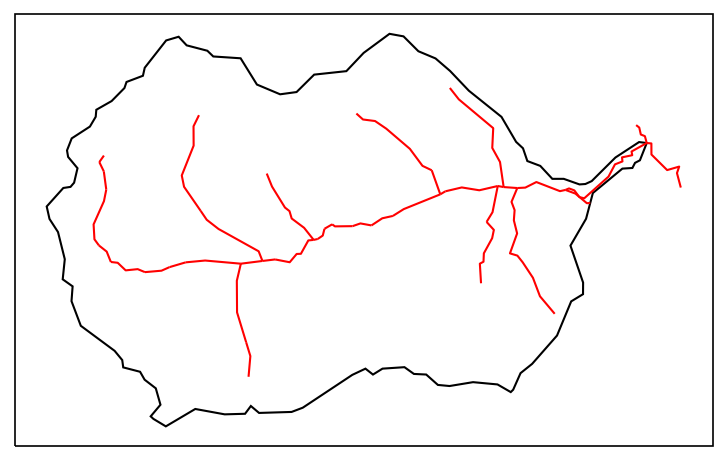

In [9]:
# plot what we have so far -- an image of the HUC and its stream network
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

watershed_workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
watershed_workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)

plt.show()

### Meshing

Triangulation refinement: refine triangles if their area (in m^2) is greater than A(d), where d is the distance from the triangle centroid to the nearest stream. A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and linearly interpolates between the two endpoints.

Adjust distance and area parameters to refine triangles. 

<span style="color:blue;"> Be careful with the min triangular area (e.g., \<1 m^2) in the meshes. It will likely cause the model to run extremely slowly. You may also receive an error saying the tolerance value (i.e., the minimum node distance) is too small.</span> You can increase the smoothing parameter such as `simplify_hucs` or `simplify_rivers` to make the boundaries smoother and meshes coarser.


2023-07-19 19:11:46,599 - root - INFO: 
2023-07-19 19:11:46,603 - root - INFO: Meshing
2023-07-19 19:11:46,606 - root - INFO: ------------------------------
2023-07-19 19:11:46,644 - root - INFO: Triangulating...
2023-07-19 19:11:46,654 - root - INFO:    98 points and 98 facets
2023-07-19 19:11:46,657 - root - INFO:  checking graph consistency
2023-07-19 19:11:46,662 - root - INFO:  tolerance is set to 1
2023-07-19 19:11:46,676 - root - INFO:  building graph data structures
2023-07-19 19:11:46,690 - root - INFO:  triangle.build...
2023-07-19 19:11:57,261 - root - INFO:   ...built: 2897 mesh points and 5610 triangles
2023-07-19 19:11:57,265 - root - INFO: Plotting triangulation diagnostics
2023-07-19 19:12:00,683 - root - INFO:   min area = 1569.3751220703125
2023-07-19 19:12:00,687 - root - INFO:   max area = 49649.99279785156


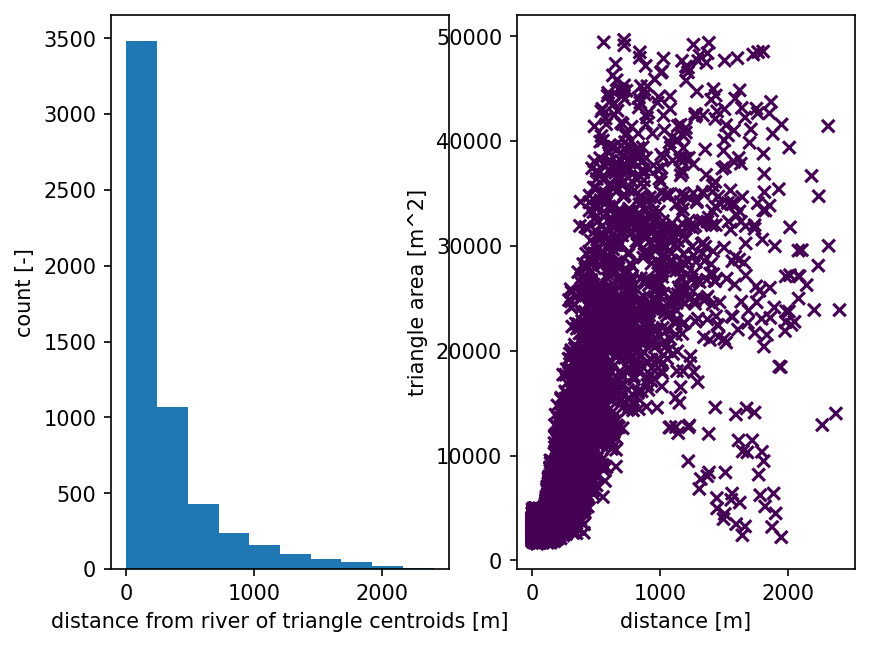

In [10]:
# form a triangulation on the shape + river network

# triangulation refinement:
# Refine triangles if their area (in m^2) is greater than A(d), where d is the 
# distance from the triangle centroid to the nearest stream.
# A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and
# linearly interpolates between the two endpoints.
d0 = 100; d1 = 500 # distance in meters
A0 = 5000; A1 = 50000 # triangular area in m^2
#A0 = 500; A1 = 2500
#A0 = 100; A1 = 500

# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
mesh_points2, mesh_tris, areas, dists = watershed_workflow.triangulate(watershed, rivers, 
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               diagnostics=True)


In [11]:
# get a raster for the elevation map, based on NED
dem_profile, dem = watershed_workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs)

# elevate the triangle nodes to the dem
mesh_points3 = watershed_workflow.elevate(mesh_points2, crs, dem, dem_profile)

2023-07-19 19:12:02,739 - root - INFO: 
2023-07-19 19:12:02,743 - root - INFO: Loading Raster
2023-07-19 19:12:02,748 - root - INFO: ------------------------------
2023-07-19 19:12:02,751 - root - INFO: Collecting raster
2023-07-19 19:12:02,768 - root - INFO: Collecting DEMs to tile bounds: [-107.11634327399999, 38.817702882000034, -106.96736783099998, 38.90466788700003]
2023-07-19 19:12:02,775 - root - INFO:   Need:
2023-07-19 19:12:02,778 - root - INFO:     /home/jovyan/data/dem/USGS_NED_1as_n39_w108.tif
2023-07-19 19:12:02,782 - root - INFO:     /home/jovyan/data/dem/USGS_NED_1as_n39_w107.tif
2023-07-19 19:12:02,790 - root - INFO: source files already exist!
2023-07-19 19:12:03,009 - root - INFO: ... got raster of shape: (313, 536)
2023-07-19 19:12:03,018 - root - INFO: ... got raster bounds: (-107.11634327399999, 38.90466788700003, -106.96745438510615, 38.81772344247477)


Plotting the resulting mesh can be done in a variety of ways, including both 3D plots and mapview.  We show both here, but hereafter use mapview plots as they are a bit clearer (if not so flashy)...

[Text(4299000.0, 0, ''),
 Text(4300000.0, 0, ''),
 Text(4301000.0, 0, ''),
 Text(4302000.0, 0, ''),
 Text(4303000.0, 0, ''),
 Text(4304000.0, 0, ''),
 Text(4305000.0, 0, ''),
 Text(4306000.0, 0, ''),
 Text(4307000.0, 0, ''),
 Text(4308000.0, 0, '')]

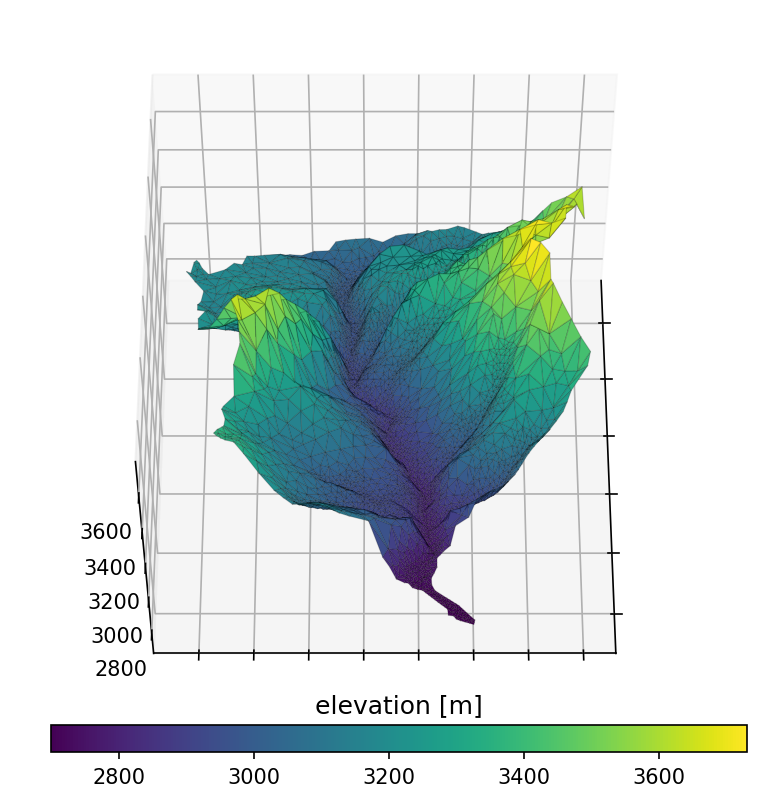

In [12]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize_3d)
ax = watershed_workflow.plot.get_ax('3d', fig, window=[0.0,0.2,1,0.8])
cax = fig.add_axes([0.23,0.18,0.58,0.03])

mp = ax.plot_trisurf(mesh_points3[:,0], mesh_points3[:,1], mesh_points3[:,2], 
                     triangles=mesh_tris, cmap='viridis', 
                     edgecolor=(0,0,0,.2), linewidth=0.5)
cb = fig.colorbar(mp, orientation="horizontal", cax=cax)

t = cax.set_title('elevation [m]')
ax.view_init(55,0)
ax.set_xticklabels(list())
ax.set_yticklabels(list())


(316658.3121175361, 329703.25353174284)
(4296859.719285354, 4309904.660699561)


Text(0.5, 1.0, 'Elevation [m]')

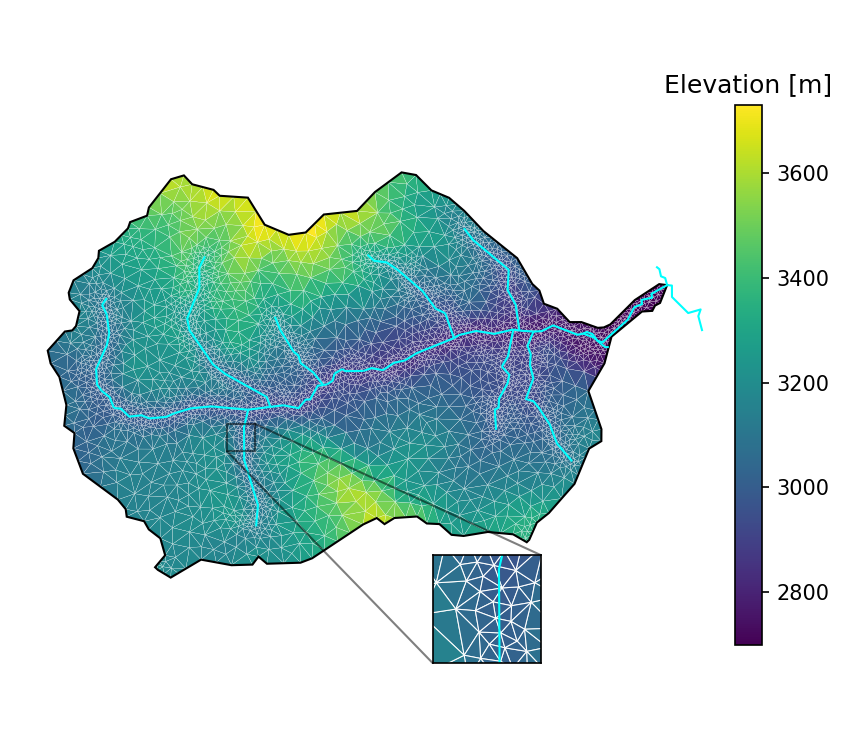

In [13]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.8,0.8])
#ax2 = workflow.plot.get_ax(crs,fig, window=[0.65,0.05,0.3,0.5])
ax2 = ax.inset_axes([0.58,0.10,0.15,0.15])
cbax = fig.add_axes([.85,0.2,0.03,0.6])

xlim = (320500., 321000.)
ylim = (4302000., 4302500.)

mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color='elevation', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
watershed_workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
watershed_workflow.plot.rivers(rivers, crs, ax=ax, color='aqua', linewidth=1)
ax.set_aspect('equal', 'datalim')

mp2 = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
                                 color='elevation', edgecolor='white', linewidth=0.5)
watershed_workflow.plot.hucs(watershed, crs, ax=ax2, color='k', linewidth=1)
watershed_workflow.plot.rivers(rivers, crs, ax=ax2, color='aqua', linewidth=1)
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_aspect('equal', 'datalim')
ax.indicate_inset_zoom(ax2, edgecolor='k')

# add scalebar, use 1 for UTM coordinates, the default unit is "m"
# scalebar1 = ScaleBar(1, location = "lower left", pad=3, frameon=False)
# ax.add_artist(scalebar1)
ax.axis('off')
print(ax.get_xlim())
print(ax.get_ylim())
cbar.ax.set_title('Elevation [m]')
# fig.savefig('../figures/watershed_mesh-2d.jpg',dpi=300)

In [14]:
# construct the 2D mesh
m2 = watershed_workflow.mesh.Mesh2D(mesh_points3.copy(), list(mesh_tris))

Condition the mesh to remove pits and ponds in the meshes. <span style="color:blue;">Advanced tip: use `fill_pits_dual(m2, is_waterbody=waterbody_mask) ` if there exists lakes or reservoirs where pits should not be removed! </span>

max diff =  93.59001668278142


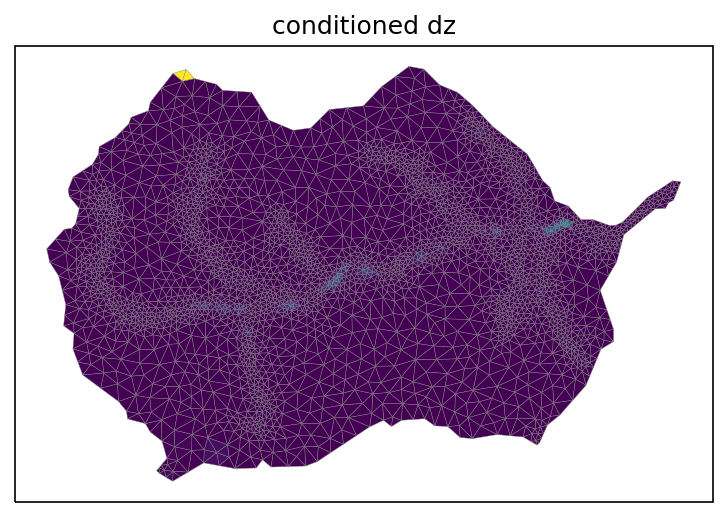

In [15]:
# hydrologically condition the mesh, removing pits
watershed_workflow.condition.fill_pits(m2)

# plot the change between the two meshes
diff = np.copy(mesh_points3)
diff[:,2] = m2.points[:,2] - mesh_points3[:,2] 
print("max diff = ", np.abs(diff[:,2]).max())
fig, ax = watershed_workflow.plot.get_ax(crs, figsize=figsize)
watershed_workflow.plot.triangulation(diff, m2.conn, crs, color='elevation', edgecolors='gray', 
                            linewidth=0.2, ax=ax)
ax.set_title('conditioned dz')
plt.show()

### Add watershed outlet (optional)

This will add the outlet region in the mesh for better capturing the streamflow in post-processing. Here there is only one catchment with one outlet. However, this may be necessary for watershed with multiple subcatchments with multiple outlets.

In [16]:
list(watershed.polygons())[0].properties

OrderedDict([('OBJECTID', 11223.0),
             ('TNMID', '{C3DA8896-4FF3-4B2F-A382-3B4AFDC6D77E}'),
             ('METASOURCE', None),
             ('SOURCEDATA', None),
             ('SOURCEORIG', None),
             ('SOURCEFEAT', None),
             ('LOADDATE', '2013/01/18 07:08:08.000'),
             ('GNIS_ID', None),
             ('AREAACRES', 13146.76),
             ('AREASQKM', 53.2),
             ('STATES', 'CO'),
             ('HUC12', '140200010204'),
             ('NAME', 'Coal Creek'),
             ('HUTYPE', 'S'),
             ('HUMOD', 'NM'),
             ('TOHUC', '140200010205'),
             ('NONCONTRIB', 0.0),
             ('NONCONTR_1', 0.0),
             ('Shape_Leng', 0.357147902089145),
             ('Shape_Area', 0.005521609626425)])

Identify outlets for each catchment. Plot the outlets to verify the correct outlet locations.

Available functions to find the outlets include:
- `find_outlets_by_crossings()`: find all outlets using river network's crossing points on HUC boundary. This may not work well if river has multiple crossings on the same boundary.
- `find_outlets_by_elevation()`: find all outlets by the minimum elevation. This does not work if the minimum elevation within the watershed is not located at the outlet.
- `find_outlets_by_hydroseq()`: find outlets using the HydroSequence VAA of NHDPlus. This may take a while.

In [17]:
watershed_workflow.split_hucs.find_outlets_by_elevation(watershed, crs, dem, dem_profile)

In [18]:
# add labeled sets for subcatcprojectnts and outlets. 
# Here we use HUC12 code, but any other labels would work.
outlet_width = 500  # half-width (unit is the same as in watershed CRS) to track a labeled set on which to get discharge. Use large values to be conservative.
watershed_polygons = list(watershed.polygons())
catchment_labels = [str(p.properties['HUC12']) for p in watershed_polygons]

watershed_workflow.mesh.add_watershed_regions_and_outlets(m2, watershed, 
                                                outlet_width=outlet_width, 
                                               labels=catchment_labels)

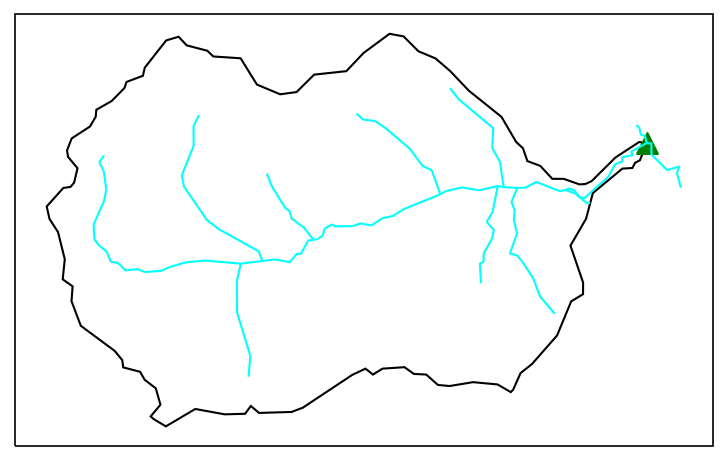

In [19]:
# plot outlets
# fig,ax=plt.subplots(1,1,figsize=(6,4))
fig, ax = watershed_workflow.plot.get_ax(crs, figsize=figsize)
watershed_workflow.plot.hucs(watershed, crs, color='k', outlet_marker = '^', ax =ax, linewidth=1)
watershed_workflow.plot.rivers(rivers, crs,  color='aqua', ax =ax, linewidth=1)

In [20]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : "{ls.name}"')

10000 : CELL : "140200010204"
10001 : CELL : "140200010204 surface"
10002 : FACE : "140200010204 boundary"
10003 : FACE : "140200010204 outlet"
10004 : FACE : "surface domain outlet"


In [21]:
config['catchment_labels'] = catchment_labels

## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed.

### Land Cover

In [22]:
# download the NLCD raster
lc_profile, lc_raster = watershed_workflow.get_raster_on_shape(sources['land cover'], 
                                                     watershed.exterior(), crs)

# resample the raster to the triangles
lc = watershed_workflow.values_from_raster(m2.centroids, crs, lc_raster, lc_profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))


2023-07-19 19:12:18,507 - root - INFO: 
2023-07-19 19:12:18,511 - root - INFO: Loading Raster
2023-07-19 19:12:18,516 - root - INFO: ------------------------------
2023-07-19 19:12:18,522 - root - INFO: Collecting raster
2023-07-19 19:12:19,365 - root - INFO: bounds in my_crs: (-952551.1064432578, 1811083.3381282836, -941371.5911290408, 1818385.78533155)
2023-07-19 19:12:19,425 - root - INFO: ... got raster of shape: (245, 374)
2023-07-19 19:12:20,044 - root - INFO: ... got raster bounds: (-952575.0, 1818405.0, -941355.0, 1811055.0)
2023-07-19 19:12:21,326 - root - INFO: Found land cover dtypes: uint8
2023-07-19 19:12:21,336 - root - INFO: Found land cover types: {71, 41, 42, 43, 11, 81, 52, 21, 22, 23, 24, 90, 31, 95}


kwargs =  {'cmap': <matplotlib.colors.ListedColormap object at 0x4095163d30>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x4095162e60>, 'edgecolor': 'none', 'linewidth': 0.5}
setting face color =  [95 21 42 ... 52 42 42]


(316690.15495, 329034.55405000004, 4299344.3309, 4307420.0490999995)

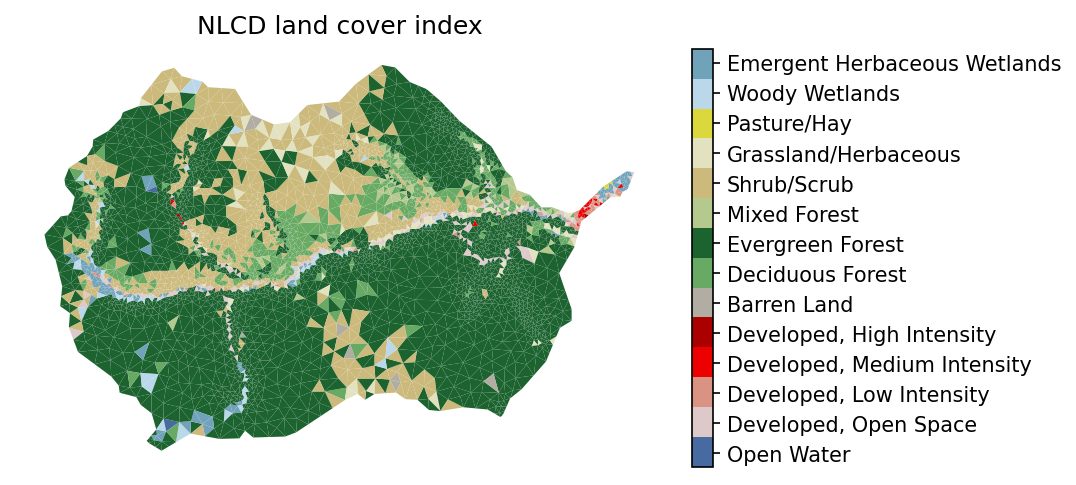

In [23]:
# plot the NLCD data

# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                watershed_workflow.colors.generate_nlcd_colormap(lc)

# plot the image
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

polys = watershed_workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=nlcd_cmap, 
                                     norm=nlcd_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)
watershed_workflow.colors.colorbar_index(ncolors=len(nlcd_indices), cmap=nlcd_cmap, 
                                         labels=nlcd_labels) 
ax.set_title("NLCD land cover index")
ax.axis('off')

In [24]:
nlcd_indices, nlcd_labels

([11, 21, 22, 23, 24, 31, 41, 42, 43, 52, 71, 81, 90, 95],
 ['Open Water',
  'Developed, Open Space',
  'Developed, Low Intensity',
  'Developed, Medium Intensity',
  'Developed, High Intensity',
  'Barren Land',
  'Deciduous Forest',
  'Evergreen Forest',
  'Mixed Forest',
  'Shrub/Scrub',
  'Grassland/Herbaceous',
  'Pasture/Hay',
  'Woody Wetlands',
  'Emergent Herbaceous Wetlands'])

In [25]:
# # add labeled sets to the mesh for NLCD
# nlcd_labels_dict = dict(zip(nlcd_indices, nlcd_labels))
# watershed_workflow.mesh.add_nlcd_labeled_sets(m2, lc, nlcd_labels_dict)

# for ls in m2.labeled_sets:
#     print(f'{ls.setid} : {ls.entity} : "{ls.name}"')

### LAI
<a id='lai'></a>
Download MODIS LAI and LULC, block until it is finished!
NOTE: if you get an error here about MODIS AppEEARs username and password, realize that you must register for a login in the AppEEARs database.  See: `print(sources['lai'].__doc__)`

You may encounter download issues if the files are too big. In that case, manually download the MODIS data using [AppEEARS](https://appeears.earthdatacloud.nasa.gov/). Here are brief steps:

1. Sign in if you already registered. 
2. Click `Extract --> Area`
3. Click `Start a new request`
4. Upload the watershed shapefile (in lat-lon). <span style="color:blue;"> Important: draw a box region surrounding the watershed to avoid downloading no_data! </span>
5. Choose `Start Date` (e.g., 2002-7-1) and `End Date` (e.g., 2021-1-1)
6. Select product for Landcover (e.g., `MCD12Q1.006`) or LAI (e.g., `MCD15A3H.006`)
7. Select layers or for landcover (i.e., `LC_Type1`) or LAI (i.e., `Lai_500m`). You may choose to include all layers, but not all will be used.
8. Select `NetCDF-4` as the output file format 
9. Click `Submit`. It will send an email after download is completed.

In [26]:
## Uncomment the next three lines if you want to try downloading through WW
# modis = sources['lai'].get_data(watershed.exterior(), crs, start, end)
# if not isinstance(modis, watershed_workflow.datasets.State):
#     modis = sources['lai'].wait(modis)
modis = sources['lai'].get_data(watershed.exterior(), crs, variables = ['LULC', 'LAI'], filenames=[watershed_modis_lulc, watershed_modis_lai])

2023-07-19 19:12:30,202 - root - INFO: ... reading LULC from ../../data/examples/CoalCreek/sources/land_cover/MODIS/MCD12Q1.006_500m_aid0001.nc
2023-07-19 19:12:30,329 - root - INFO: ... reading LAI from ../../data/examples/CoalCreek/sources/land_cover/MODIS/MCD15A3H.006_500m_aid0001.nc


In [27]:
modis['LULC'].times

array([datetime.date(2002, 1, 1), datetime.date(2003, 1, 1),
       datetime.date(2004, 1, 1), datetime.date(2005, 1, 1),
       datetime.date(2006, 1, 1), datetime.date(2007, 1, 1),
       datetime.date(2008, 1, 1), datetime.date(2009, 1, 1),
       datetime.date(2010, 1, 1), datetime.date(2011, 1, 1),
       datetime.date(2012, 1, 1), datetime.date(2013, 1, 1),
       datetime.date(2014, 1, 1), datetime.date(2015, 1, 1),
       datetime.date(2016, 1, 1), datetime.date(2017, 1, 1),
       datetime.date(2018, 1, 1), datetime.date(2019, 1, 1),
       datetime.date(2020, 1, 1)], dtype=object)

In [28]:
# select the year of 2016 for MODIS landcover to match 2016 NLCD land cover
lc_idx = np.where(modis['LULC'].times == datetime.date(2016, 1, 1))[0][0]
lc_idx

14

In [29]:
# resample the raster to the triangles
modis_lc = watershed_workflow.values_from_raster(m2.centroids, crs, modis['LULC'].data[lc_idx,:,:], 
                                                 modis['LULC'].profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(modis_lc.dtype))
logging.info('Found land cover types: {}'.format(set(modis_lc)))

2023-07-19 19:12:30,978 - root - INFO: Found land cover dtypes: int16
2023-07-19 19:12:30,985 - root - INFO: Found land cover types: {8, 9, 10, 1}


kwargs =  {'cmap': <matplotlib.colors.ListedColormap object at 0x4095a37880>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x4095a370d0>, 'edgecolor': 'none', 'linewidth': 0.5}
setting face color =  [ 9 10  9 ...  8  9  8]


(316690.15495, 329034.55405000004, 4299344.3309, 4307420.0490999995)

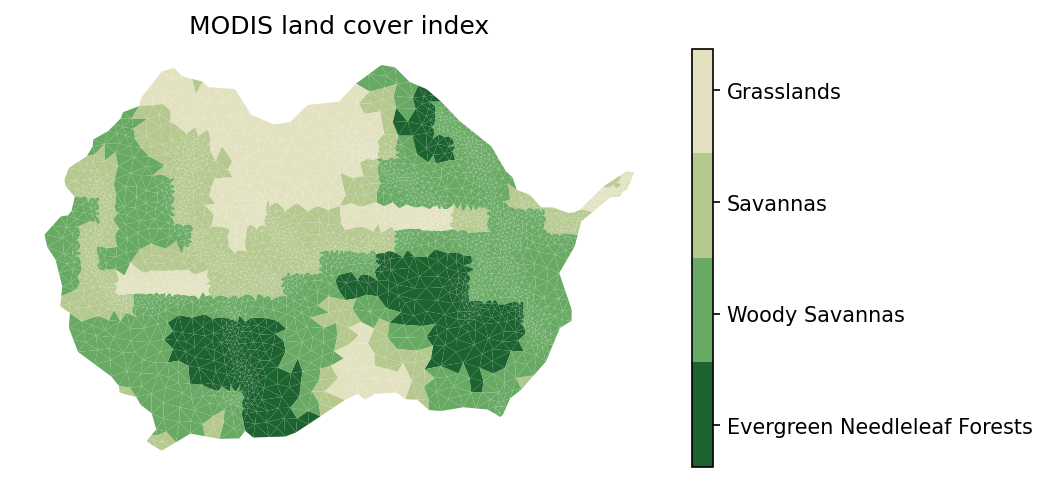

In [30]:
# plot the modis lulc data

# -- get the MODIS colormap which uses official MODIS colors and labels
modis_indices, modis_cmap, modis_norm, modis_ticks, modis_labels = \
                watershed_workflow.colors.generate_modis_colormap(modis_lc)

# plot the image
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

polys = watershed_workflow.plot.mesh(m2, crs, ax=ax, color=modis_lc, cmap=modis_cmap, 
                                     norm=modis_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)
watershed_workflow.colors.colorbar_index(ncolors=len(modis_indices), cmap=modis_cmap, 
                                         labels=modis_labels) 
ax.set_title("MODIS land cover index")
ax.axis('off')

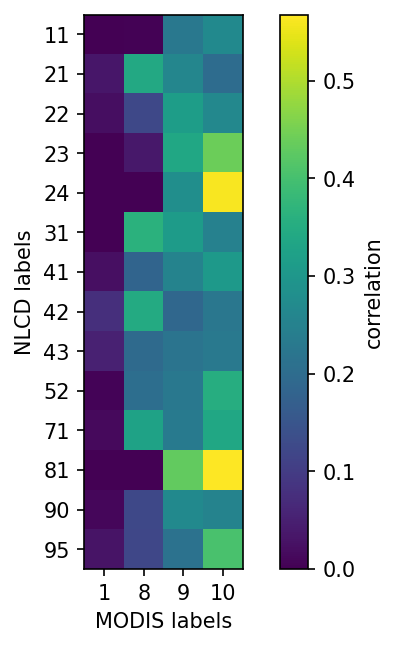

In [31]:
# determine a crosswalk between NLCD and MODIS -- for each NLCD index, 
# what MODIS index correlates best.  
unique_nlcd = list(np.unique(lc))
unique_modis = modis_indices

crosswalk = watershed_workflow.land_cover_properties.compute_crosswalk_correlation(
    modis['LULC'].profile, modis['LULC'].data[lc_idx,:,:], lc_profile, lc_raster, unique_nlcd = unique_nlcd, unique_modis=unique_modis)

In [32]:
# print the crosswalk.
crosswalk

{11: 10,
 21: 8,
 22: 9,
 23: 10,
 24: 10,
 31: 8,
 41: 10,
 42: 8,
 43: 10,
 52: 10,
 71: 10,
 81: 10,
 90: 9,
 95: 10}

In [33]:
nlcd_color_new = 99 * np.ones_like(lc)

for k,v in crosswalk.items():
    # for label in v:
    # index = sources['land cover'].indices[label]
    nlcd_color_new[np.where(lc == k)] = v

In [34]:
np.unique(nlcd_color_new)

array([ 8,  9, 10], dtype=uint8)

/opt/conda/envs/watershed_workflow/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'cmap': <matplotlib.colors.ListedColormap object at 0x4095b28640>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x4095b2ad10>, 'edgecolor': 'none', 'linewidth': 0.5}
setting face color =  [10  8  8 ... 10  8  8]


(316690.15495, 329034.55405000004, 4299344.3309, 4307420.0490999995)

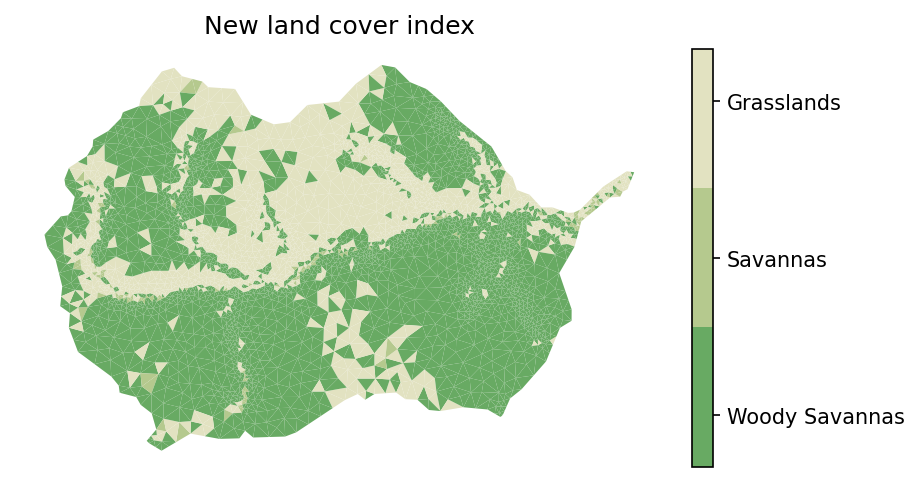

In [35]:
# plot new NLCD data

# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices_new, nlcd_cmap_new, nlcd_norm_new, nlcd_ticks_new, nlcd_labels_new = \
                watershed_workflow.colors.generate_modis_colormap(nlcd_color_new)

# plot the image
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

polys = watershed_workflow.plot.mesh(m2, crs, ax=ax, color=nlcd_color_new, cmap=nlcd_cmap_new, 
                                     norm=nlcd_norm_new, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)
watershed_workflow.colors.colorbar_index(ncolors=len(nlcd_indices_new), cmap=nlcd_cmap_new, 
                                         labels=nlcd_labels_new) 
ax.set_title("New land cover index")
ax.axis('off')

In [36]:
nlcd_indices_new, nlcd_labels_new

([8, 9, 10], ['Woody Savannas', 'Savannas', 'Grasslands'])

In [37]:
# add labeled sets to the mesh for new NLCD
nlcd_labels_new = ['MODIS ' + i for i in nlcd_labels_new]
nlcd_labels_dict = dict(zip(nlcd_indices_new, nlcd_labels_new))
watershed_workflow.mesh.add_nlcd_labeled_sets(m2, nlcd_color_new, nlcd_labels_dict)

In [38]:
config['nlcd_indices'] = [int(i) for i in nlcd_indices_new]
config['nlcd_labels'] = nlcd_labels_new

In [39]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : "{ls.name}"')

10000 : CELL : "140200010204"
10001 : CELL : "140200010204 surface"
10002 : FACE : "140200010204 boundary"
10003 : FACE : "140200010204 outlet"
10004 : FACE : "surface domain outlet"
8 : CELL : "MODIS Woody Savannas"
9 : CELL : "MODIS Savannas"
10 : CELL : "MODIS Grasslands"


In [40]:
# compute area averaged LAI for each modis land cover
lai_time_series = watershed_workflow.land_cover_properties.compute_time_series(
modis['LAI'], modis['LULC'], unique_lc = unique_modis, lc_idx = lc_idx)
lai_time_series

time [datetime]  MODIS Evergreen Needleleaf Forests LAI [-]  \
0         2002-07-04                                    1.589855   
1         2002-07-08                                    1.847826   
2         2002-07-12                                    2.168116   
3         2002-07-16                                    2.186957   
4         2002-07-20                                    1.518841   
...              ...                                         ...   
1694      2020-12-18                                    0.957971   
1695      2020-12-22                                    0.563768   
1696      2020-12-26                                    0.556522   
1697      2020-12-30                                    0.602899   
1698      2021-01-01                                    0.947826   

      MODIS Woody Savannas LAI [-]  MODIS Savannas LAI [-]  \
0                         1.616497                1.184228   
1                         1.639086                1.178188   
2                         1.817005                1.337584   
3                         2.015482                1.410403   
4                         1.466751                0.984228   
...                            ...                     ...   
1694                      0.845431                0.350671   
1695                      0.481980                0.199664   
1696                      0.356853                0.145302   
1697                      0.407107                0.200671   
1698                      0.579695                0.160738   

      MODIS Grasslands LAI [-]  
0                     1.017632  
1                     0.983158  
2                     1.112895  
3                     1.103158  
4                     0.865000  
...                        ...  
1694                  0.200789  
1695                  0.102895  
1696                  0.073158  
1697                  0.087632  
1698                  0.090000  

[1699 rows x 5 columns]

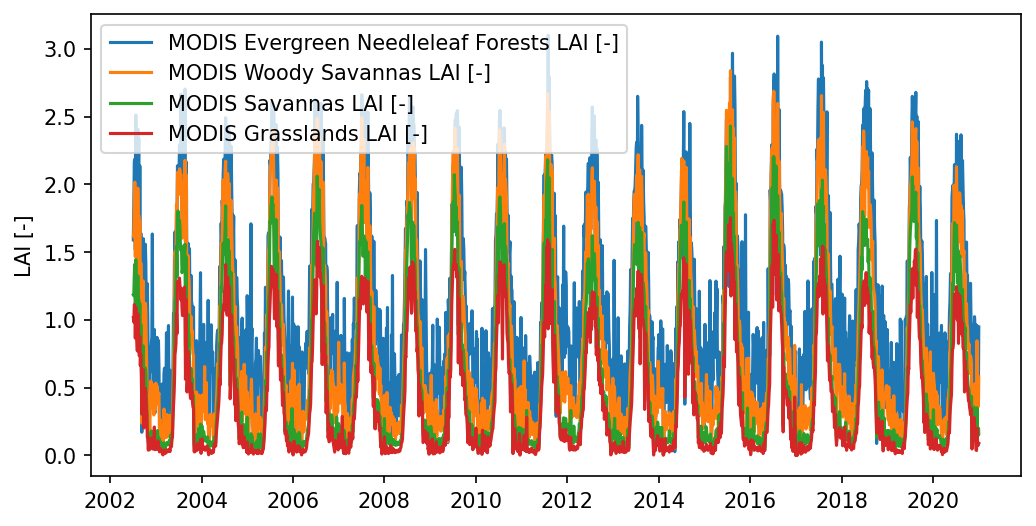

In [41]:
# plot LAI
fig,ax = plt.subplots(1,1, figsize=(8,4))
times = pandas.to_datetime(lai_time_series['time [datetime]'])
for icol in lai_time_series.columns[1:]:
    ax.plot(times, lai_time_series[icol], label = icol)
plt.ylabel("LAI [-]")
ax.legend()

In [42]:
# write raw LAI to disk
config['LAI_filename'] = os.path.join('..', '..', 'data', 'examples', watershed_name, 'processed', 'watershed_lai_raw.h5')
watershed_workflow.io.write_timeseries_to_hdf5(config['LAI_filename'], lai_time_series, 
                                              attributes={'name': 'MODIS LAI based on MODIS LULC',
                                                         'unit': 'none'}, time0=origin_date)                                            

2023-07-19 19:12:53,160 - root - INFO: Writing HDF5 file: ../../data/examples/CoalCreek/processed/watershed_lai_raw.h5


Generate smoothed MODIS LAI data for spinup runs.

In [43]:
# compute area averaged LAI for each modis land cover
lai_time_series_smoothed = watershed_workflow.land_cover_properties.compute_time_series(
modis['LAI'], modis['LULC'], unique_lc = unique_modis, lc_idx = lc_idx, smooth=True)
lai_time_series_smoothed

time [datetime]  MODIS Evergreen Needleleaf Forests LAI [-]  \
0         2002-07-04                                    1.626218   
1         2002-07-05                                    1.678844   
2         2002-07-06                                    1.728293   
3         2002-07-07                                    1.774630   
4         2002-07-08                                    1.817918   
...              ...                                         ...   
6752      2020-12-28                                    0.675724   
6753      2020-12-29                                    0.671858   
6754      2020-12-30                                    0.667734   
6755      2020-12-31                                    0.663339   
6756      2021-01-01                                    0.658664   

      MODIS Woody Savannas LAI [-]  MODIS Savannas LAI [-]  \
0                         1.615882                1.185884   
1                         1.633757                1.196320   
2                         1.650247                1.205861   
3                         1.665379                1.214525   
4                         1.679181                1.222327   
...                            ...                     ...   
6752                      0.490863                0.192045   
6753                      0.495014                0.192953   
6754                      0.499303                0.193928   
6755                      0.503729                0.194968   
6756                      0.508288                0.196070   

      MODIS Grasslands LAI [-]  
0                     0.996145  
1                     1.002076  
2                     1.007377  
3                     1.012063  
4                     1.016144  
...                        ...  
6752                  0.093669  
6753                  0.093393  
6754                  0.093184  
6755                  0.093040  
6756                  0.092960  

[6757 rows x 5 columns]

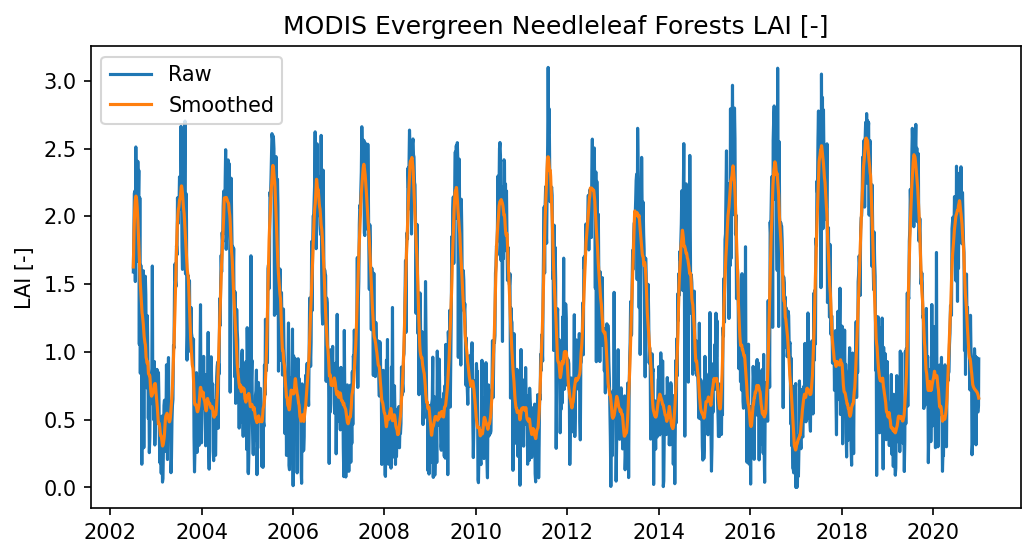

In [44]:
# plot LAI
ilc = lai_time_series.columns[1]
fig,ax = plt.subplots(1,1, figsize=(8,4))
times = pandas.to_datetime(lai_time_series['time [datetime]'])
new_times = pandas.to_datetime(lai_time_series_smoothed['time [datetime]'])

ax.plot(times, lai_time_series[ilc], label = "Raw")
ax.plot(new_times, lai_time_series_smoothed[ilc], label = "Smoothed")
plt.ylabel("LAI [-]")
plt.title(ilc)
ax.legend()

In [45]:
lai_time_series_smoothed["time [datetime]"] = pandas.to_datetime(lai_time_series_smoothed["time [datetime]"])
lai_time_series_smoothed.set_index("time [datetime]", inplace=True)

<AxesSubplot:xlabel='time [datetime],time [datetime]'>

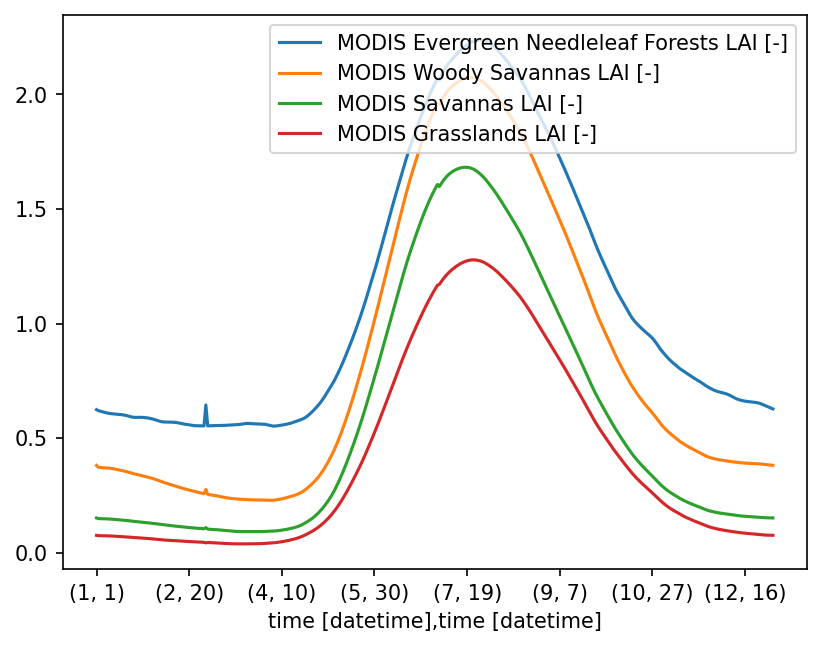

In [46]:
lai_avg=lai_time_series_smoothed.groupby([lai_time_series_smoothed.index.month, lai_time_series_smoothed.index.day]).mean()
lai_avg.plot()

In [47]:
# repeat for 40 years
lai_typical = pandas.DataFrame(np.tile(lai_avg.values[:-1,:], (40, 1)), columns=lai_avg.columns)
lai_typical['time [s]'] = ATSutils.sec_noleap().iloc[:lai_typical.shape[0], ].values
lai_typical

MODIS Evergreen Needleleaf Forests LAI [-]  \
0                                        0.624212   
1                                        0.619714   
2                                        0.617371   
3                                        0.615117   
4                                        0.612984   
...                                           ...   
14595                                    0.644767   
14596                                    0.641196   
14597                                    0.637604   
14598                                    0.633966   
14599                                    0.630448   

       MODIS Woody Savannas LAI [-]  MODIS Savannas LAI [-]  \
0                          0.380460                0.151158   
1                          0.372474                0.148457   
2                          0.371603                0.148243   
3                          0.370879                0.148019   
4                          0.370297                0.147774   
...                             ...                     ...   
14595                      0.385057                0.152636   
14596                      0.383983                0.152196   
14597                      0.383063                0.151849   
14598                      0.382276                0.151593   
14599                      0.381657                0.151440   

       MODIS Grasslands LAI [-]    time [s]  
0                      0.075328           0  
1                      0.074082       86400  
2                      0.073763      172800  
3                      0.073519      259200  
4                      0.073339      345600  
...                         ...         ...  
14595                  0.076993  1261008000  
14596                  0.076507  1261094400  
14597                  0.076132  1261180800  
14598                  0.075871  1261267200  
14599                  0.075720  1261353600  

[14600 rows x 5 columns]

In [48]:
# write to disk
config['LAI_typical_filename'] = os.path.join('..', '..', 'data', 'examples', watershed_name, 'processed', 'watershed_lai_typical.h5')
attributes={'name':f'Typical LAI generated MODIS LAI data from {times[0]} to {times[len(times)-1]}, averaged for all days across each year, then repeated for 40 years',
           'origin date':origin_date}

with h5py.File(config['LAI_typical_filename'],'w') as fid:
    for k in lai_typical:
        fid.create_dataset(k, data=lai_typical[k][:])
    for key, val in attributes.items():
        fid.attrs[key] = val

## Subsurface properties

Get soil structure from SSURGO.  By soil structure, here we calculate, for each formation identified in SSURGO, a soil depth, porosity, permeability, and percent sand/silt/clay (which are then handed off to Rosetta to get a van Genuchten model). 

Below this soil we also identify a geologic layer provided by GLHYMPS.  This provides information about the deeper subsurface.

### SSURGO Soil Properties

In [49]:
# download the NRCS soils data as shapes and project it onto the mesh

# -- download the shapes
soil_profile, soil_survey, soil_survey_props = \
        watershed_workflow.get_shapes(sources['soil structure'], [watershed.exterior(),],
                                      crs, crs, properties=True)


# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = np.array(soil_survey_props['mukey'][:], np.int32)
    
# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_profile, soil_color_raster = watershed_workflow.color_raster_from_shapes(soil_survey, crs, soil_ids,
                                                                                    watershed.exterior().bounds, 10, crs, -1)

# -- resample the raster to the triangles
soil_color = watershed_workflow.values_from_raster(m2.centroids, crs, 
                                         soil_color_raster, soil_color_profile)



soil_color = soil_color.astype(int)

2023-07-19 19:12:58,836 - root - INFO: 
2023-07-19 19:12:58,840 - root - INFO: Loading shapes
2023-07-19 19:12:58,842 - root - INFO: ------------------------------
2023-07-19 19:12:58,937 - root - INFO: Attempting to download source for target '/home/jovyan/data/soil_structure/SSURGO/SSURGO_-107.1073_38.8271_-106.9759_38.8957.shp'
2023-07-19 19:12:59,139 - root - INFO:   Found 109 shapes.
2023-07-19 19:12:59,151 - root - INFO:   and crs: epsg:4326
2023-07-19 19:12:59,154 - root - INFO:   Downloaded 109 total shapes
2023-07-19 19:12:59,159 - root - INFO:   Downloaded 32 unique mukeys
2023-07-19 19:12:59,404 - root - INFO: found 32 unique MUKEYs.
2023-07-19 19:13:08,108 - root - INFO: Running Rosetta for van Genutchen parameters
2023-07-19 19:13:08,979 - root - INFO:   ... done
2023-07-19 19:13:08,996 - root - INFO:   requested 28 values
2023-07-19 19:13:08,999 - root - INFO:   got 28 responses
2023-07-19 19:13:09,071 - root - INFO: ... found 32 shapes
2023-07-19 19:13:09,074 - root - IN

/opt/conda/envs/watershed_workflow/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0, 'cmap': <matplotlib.colors.ListedColormap object at 0x4095b04d60>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x4095b053c0>}
setting face color =  [509733 509794 509532 ... 509481 509547 509481]


(316690.15495, 329034.55405000004, 4299344.3309, 4307420.0490999995)

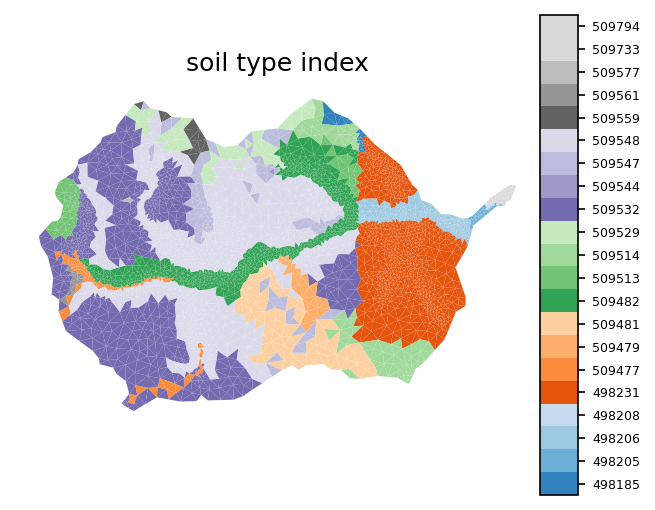

In [50]:
# plot the soil mukey
indices, cmap, norm, ticks, labels = \
        watershed_workflow.colors.generate_indexed_colormap(soil_color, cmap='tab20c')
fig, ax = watershed_workflow.plot.get_ax(crs, figsize=(5,4), window=[0.,0.,0.7,0.9])
cax = fig.add_axes([0.7,0.05,0.05,0.8])

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color, 
                        cmap=cmap, norm=norm
                       )

cbar = watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color)), 
                                                cmap=cmap, labels=labels, cax=cax)
cbar.ax.tick_params(labelsize=6)

ax.set_title('soil type index')
ax.axis('off')

In [51]:
# Note this is not just the soil ID, but also soil properties.  
# print(soil_survey_props.keys())
soil_survey_props.set_index('mukey', inplace=True)
# only select soils within the watershed
soil_survey_props = soil_survey_props.loc[np.unique(soil_color), :]
soil_survey_props

residual saturation [-]  Rosetta porosity [-]  \
mukey                                                   
498185                 0.240269              0.502882   
498205                 0.181598              0.399993   
498206                 0.181598              0.399993   
498208                 0.208316              0.428990   
498231                 0.213285              0.466663   
509477                 0.175133              0.567740   
509479                 0.230885              0.378365   
509481                 0.230885              0.378365   
509482                 0.207877              0.369886   
509513                 0.219597              0.445168   
509514                 0.241801              0.474101   
509529                 0.196811              0.356163   
509532                 0.199783              0.412306   
509544                      NaN                   NaN   
509547                      NaN                   NaN   
509548                 0.189314              0.404765   
509559                 0.210870              0.420608   
509561                 0.246665              0.467696   
509577                      NaN                   NaN   
509733                 0.157366              0.400499   
509794                 0.220962              0.383130   

        van Genuchten alpha [Pa^-1]  van Genuchten n [-]  \
mukey                                                      
498185                     0.000092             1.319916   
498205                     0.000139             1.457559   
498206                     0.000139             1.457559   
498208                     0.000071             1.420938   
498231                     0.000059             1.416784   
509477                     0.000103             1.383180   
509479                     0.000079             1.374540   
509481                     0.000079             1.374540   
509482                     0.000092             1.397760   
509513                     0.000072             1.395746   
509514                     0.000079             1.340429   
509529                     0.000157             1.406091   
509532                     0.000087             1.422578   
509544                          NaN                  NaN   
509547                          NaN                  NaN   
509548                     0.000104             1.433685   
509559                     0.000078             1.410010   
509561                     0.000081             1.332817   
509577                          NaN                  NaN   
509733                     0.000221             1.762072   
509794                     0.000140             1.367408   

        Rosetta permeability [m^2]  thickness [cm]  permeability [m^2]  \
mukey                                                                    
498185                3.617805e-13      152.000000        2.279759e-13   
498205                4.938634e-13      152.000000        2.734080e-12   
498206                4.938634e-13      152.000000        2.734080e-12   
498208                2.830658e-13      152.000000        1.184189e-12   
498231                3.782943e-13      107.000000        7.331979e-13   
509477                2.438575e-12      152.000000        3.039095e-12   
509479                1.031721e-13      125.000000        3.172415e-12   
509481                1.031721e-13      125.000000        3.172415e-12   
509482                1.474479e-13      120.500000        4.654687e-12   
509513                2.727324e-13      152.000000        9.122162e-13   
509514                2.435161e-13      152.000000        2.375523e-13   
509529                2.260935e-13      152.000000        5.850942e-12   
509532                2.966015e-13      152.000000        1.526682e-12   
509544                         NaN      152.000000        7.000000e-15   
509547                         NaN      152.000000        4.230700e-11   
509548                3.617371e-13      152.000000       

min, max =  0.15125 0.567739729619314


/opt/conda/envs/watershed_workflow/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


(316690.15495, 329034.55405000004, 4299344.3309, 4307420.0490999995)

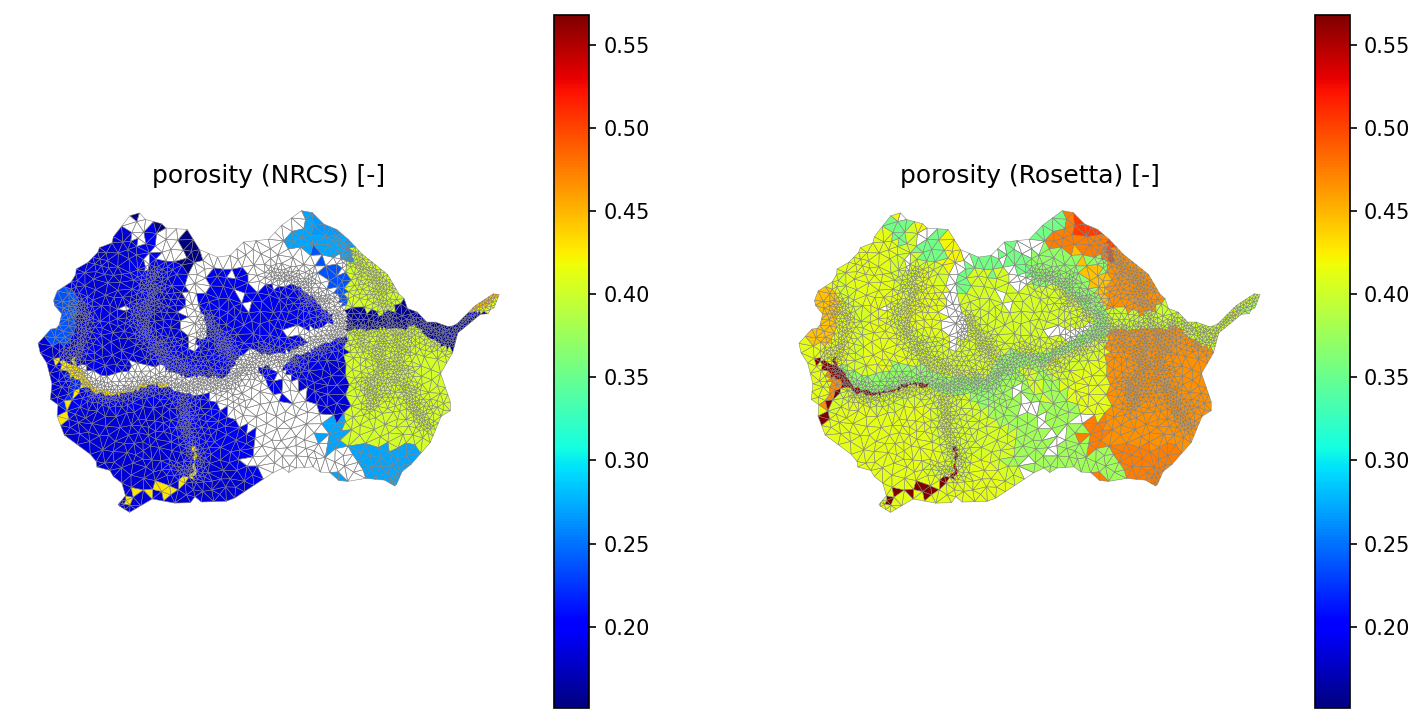

In [52]:
# To demonstrate what we mean by this, plot the porosity of the soil column.
porosity_nrcs = np.empty(soil_color.shape, 'd')
porosity_rosetta = np.empty(soil_color.shape, 'd')

for mukey in soil_survey_props.index:
    porosity_nrcs[soil_color == mukey] = soil_survey_props.loc[mukey, 'porosity [-]']
    porosity_rosetta[soil_color == mukey] = soil_survey_props.loc[mukey, 'Rosetta porosity [-]']

pmin = min(np.nanmin(porosity_nrcs), np.nanmin(porosity_rosetta))
pmax = max(np.nanmax(porosity_nrcs), np.nanmax(porosity_rosetta))
print('min, max = ', pmin, pmax)

fig = plt.figure(figsize=(12,6))
ax1 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=1)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax1, 
                color=porosity_nrcs, edgecolor='gray', cmap='jet', 
                                           vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax1.set_title('porosity (NRCS) [-]')
ax1.axis('off')


ax2 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=2)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
                                 color=porosity_rosetta, edgecolor='gray', cmap='jet', vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax2.set_title('porosity (Rosetta) [-]')
ax2.axis('off')

/tmp/ipykernel_2458/45597466.py:11: RuntimeWarning: All-NaN axis encountered
  pmin = min(np.nanmin(np.log10(soil_perm_nrcs)), np.nanmin(np.log10(soil_perm_rosetta).min()))
/tmp/ipykernel_2458/45597466.py:12: RuntimeWarning: All-NaN axis encountered
  pmax = max(np.nanmax(np.log10(soil_perm_nrcs)), np.nanmax(np.log10(soil_perm_rosetta).max()))


min = -14.154901959985743, max = -10.373587769507715


Text(0.5, 1.0, 'log permeability (Rosetta) [m^2]')

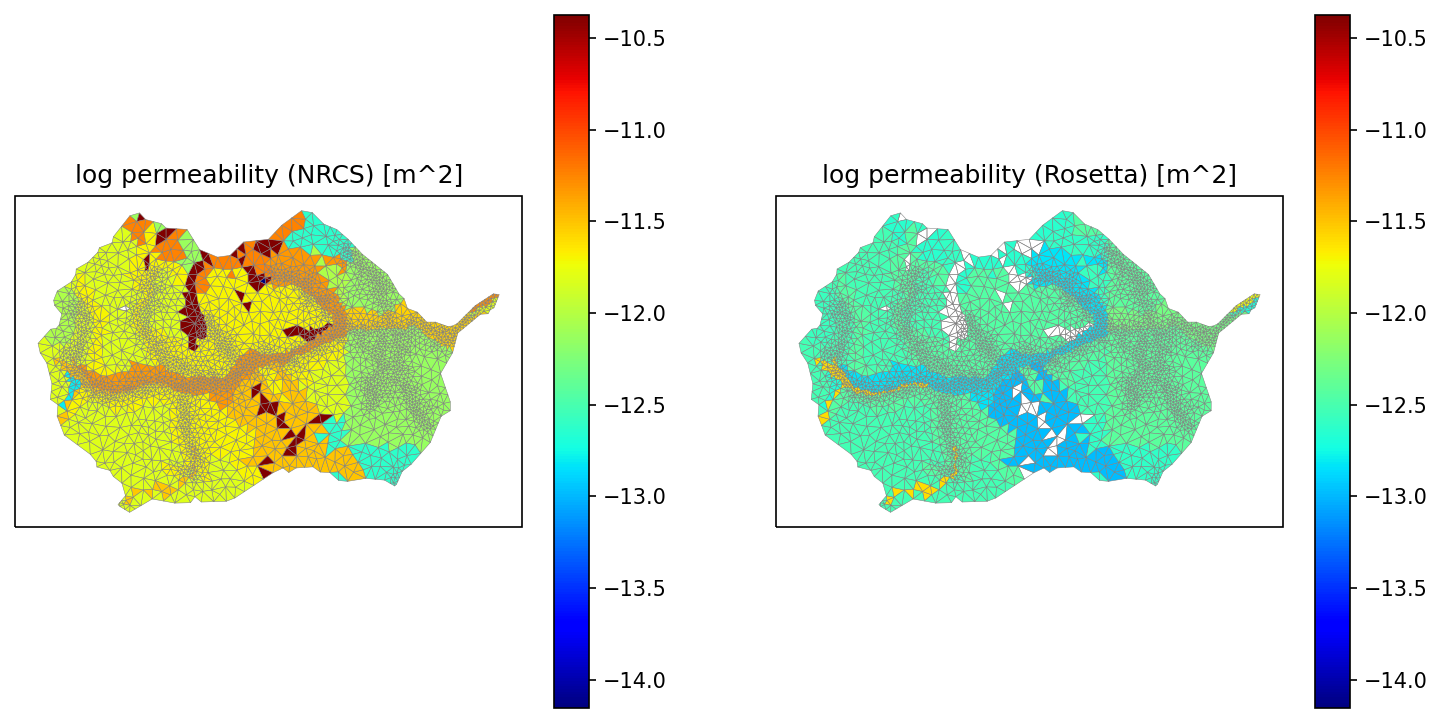

In [53]:
# averaging permeability is a tricky beast.  we average in log space, check that 
# unit conversions make sense
fig = plt.figure(figsize=(12,6))
soil_perm_nrcs = np.empty(soil_color.shape, 'd')
soil_perm_rosetta = np.empty(soil_color.shape, 'd')

for mukey in soil_survey_props.index:
    soil_perm_nrcs[soil_color == mukey] = soil_survey_props.loc[mukey, 'permeability [m^2]']
    soil_perm_rosetta[soil_color == mukey] = soil_survey_props.loc[mukey, 'Rosetta permeability [m^2]']

pmin = min(np.nanmin(np.log10(soil_perm_nrcs)), np.nanmin(np.log10(soil_perm_rosetta).min()))
pmax = max(np.nanmax(np.log10(soil_perm_nrcs)), np.nanmax(np.log10(soil_perm_rosetta).max()))

  
print(f'min = {pmin}, max = {pmax}')

ax1 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=1)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax1, 
                                 color=np.log10(soil_perm_nrcs), edgecolor='gray', cmap='jet',
                                vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax1.set_title('log permeability (NRCS) [m^2]')

ax2 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=2)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
                                 color=np.log10(soil_perm_rosetta), edgecolor='gray', cmap='jet',
                                vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax2.set_title('log permeability (Rosetta) [m^2]')




Median soil thickness = 1.52 [m]


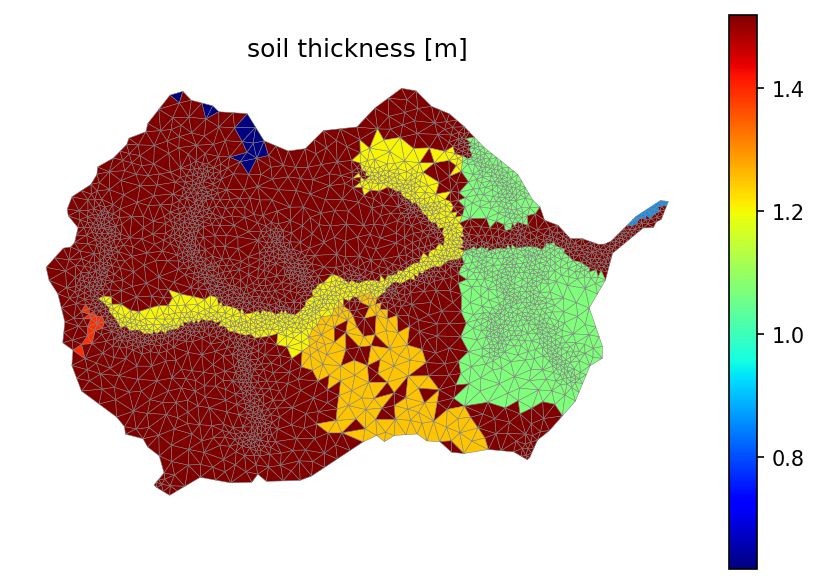

In [54]:
# finally, let's look at the soil thickness, which will define the depth of this layer
soil_thickness = np.zeros(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    soil_thickness[soil_color == mukey] = soil_survey_props.loc[mukey, 'thickness [cm]']

# print(soil_thickness)
soil_thickness = soil_thickness / 100 # convert cm to m
fig, ax = watershed_workflow.plot.get_ax(crs)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=soil_thickness, edgecolor='gray', cmap='jet')
ax.set_title('soil thickness [m]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04)
ax.axis('off')

print(f'Median soil thickness = {np.nanmedian(soil_thickness)} [m]')

In [55]:
def reindex_remove_duplicates(df, index=None):
    """Removes duplicates, creating a new index and saving the old index as tuples of duplicate values. In place!"""
    if index is not None:
        if index in df:
            df.set_index(index, drop=True, inplace=True)
    
    index_name = df.index.name

    # identify duplicate rows, use all cols as duplicate target
    duplicates = list(df.groupby(list(df)).apply(lambda x: tuple(x.index)))

    # order is preserved
    df.drop_duplicates(inplace=True)
    df.reset_index(inplace=True)
    df[index_name] = duplicates
    return

In [56]:
def replace_column_nans(df, col_nan, col_replacement):
    """In a df, replace col_nan entries by col_replacement if is nan.  In Place!"""
    row_indexer = df[col_nan].isna()
    df.loc[row_indexer, col_nan] = df.loc[row_indexer, col_replacement]
    return

In [57]:
# Note the missing data (white).  This is because some SSURGO map units have no formation with complete 
# information.  So we merge the above available data, filling where possible and dropping regions that
# do not have a complete set of properties.
# soil_survey_props_clean = soil_survey_props.copy()
soil_survey_props_clean = soil_survey_props.reset_index()

# later scripts expect 'native_index' as a standard name of holding onto the original IDs
# soil_survey_props_clean.rename_axis('native_index', inplace=True)
soil_survey_props_clean.rename(columns={'mukey':'native_index'}, inplace=True)

# need thickness in m
soil_survey_props_clean['thickness [cm]'] = soil_survey_props_clean['thickness [cm]']/100.
soil_survey_props_clean.rename(columns={'thickness [cm]':'thickness [m]'}, inplace=True)

# where poro or perm is nan, put Rosetta poro
replace_column_nans(soil_survey_props_clean, 'porosity [-]', 'Rosetta porosity [-]')
replace_column_nans(soil_survey_props_clean, 'permeability [m^2]', 'Rosetta permeability [m^2]')

# drop unnecessary columns
for col in ['Rosetta porosity [-]', 'Rosetta permeability [m^2]', 'bulk density [g/cm^3]', 'total sand pct [%]',
            'total silt pct [%]', 'total clay pct [%]']:
    soil_survey_props_clean.pop(col)

soil_survey_props_clean

native_index  residual saturation [-]  van Genuchten alpha [Pa^-1]  \
0         498185                 0.240269                     0.000092   
1         498205                 0.181598                     0.000139   
2         498206                 0.181598                     0.000139   
3         498208                 0.208316                     0.000071   
4         498231                 0.213285                     0.000059   
5         509477                 0.175133                     0.000103   
6         509479                 0.230885                     0.000079   
7         509481                 0.230885                     0.000079   
8         509482                 0.207877                     0.000092   
9         509513                 0.219597                     0.000072   
10        509514                 0.241801                     0.000079   
11        509529                 0.196811                     0.000157   
12        509532                 0.199783                     0.000087   
13        509544                      NaN                          NaN   
14        509547                      NaN                          NaN   
15        509548                 0.189314                     0.000104   
16        509559                 0.210870                     0.000078   
17        509561                 0.246665                     0.000081   
18        509577                      NaN                          NaN   
19        509733                 0.157366                     0.000221   
20        509794                 0.220962                     0.000140   

    van Genuchten n [-]  thickness [m]  permeability [m^2]  porosity [-]  \
0              1.319916       1.520000        2.279759e-13      0.265563   
1              1.457559       1.520000        2.734080e-12      0.159737   
2              1.457559       1.520000        2.734080e-12      0.159737   
3              1.420938       1.520000        1.184189e-12      0.185986   
4              1.416784       1.070000        7.331979e-13      0.403218   
5              1.383180       1.520000        3.039095e-12      0.428779   
6              1.374540       1.250000        3.172415e-12      0.378365   
7              1.374540       1.250000        3.172415e-12      0.378365   
8              1.397760       1.205000        4.654687e-12      0.369886   
9              1.395746       1.520000        9.122162e-13      0.237423   
10             1.340429       1.520000        2.375523e-13      0.271630   
11             1.406091       1.520000        5.850942e-12      0.356163   
12             1.422578       1.520000        1.526682e-12      0.182238   
13                  NaN       1.520000        7.000000e-15           NaN   
14                  NaN       1.520000        4.230700e-11           NaN   
15             1.433685       1.520000        2.006536e-12      0.193350   
16             1.410010       0.618125        7.504374e-13      0.151250   
17             1.332817       1.396471        1.590777e-13      0.218625   
18                  NaN       1.520000                 NaN           NaN   
19             1.762072       0.860000        5.262229e-12      0.449752   
20             1.367408       1.520000        1.554090e-12      0.415245   

   source  
0    NRCS  
1    NRCS  
2    NRCS  
3    NRCS  
4    NRCS  
5    NRCS  
6    NRCS  
7    NRCS  
8    NRCS  
9    NRCS  
10   NRCS  
11   NRCS  
12   NRCS  
13   NRCS  
14   NRCS  
15   NRCS  
16   NRCS  
17   NRCS  
18   NRCS  
19   NRCS  
20   NRCS

In [58]:
# drop nans
# soil id with missing properties will be removed, and the space will be filled by geology from below (see mesh extrusion)!
soil_survey_props_clean.dropna(inplace=True)
soil_survey_props_clean.reset_index(drop=True, inplace=True)

# remove duplicates
reindex_remove_duplicates(soil_survey_props_clean, 'native_index')

# assert soil_survey_props_clean['porosity [-]'][:].min() >= min_porosity
# assert soil_survey_props_clean['permeability [m^2]'][:].max() <= max_permeability
soil_survey_props_clean

native_index  residual saturation [-]  van Genuchten alpha [Pa^-1]  \
0          (509733,)                 0.240269                     0.000092   
1          (509477,)                 0.181598                     0.000139   
2   (498205, 498206)                 0.208316                     0.000071   
3          (509548,)                 0.213285                     0.000059   
4          (509529,)                 0.175133                     0.000103   
5          (509532,)                 0.230885                     0.000079   
6          (509482,)                 0.207877                     0.000092   
7          (498208,)                 0.219597                     0.000072   
8          (509559,)                 0.241801                     0.000079   
9          (498231,)                 0.196811                     0.000157   
10         (509513,)                 0.199783                     0.000087   
11         (509794,)                 0.189314                     0.000104   
12  (509479, 509481)                 0.210870                     0.000078   
13         (498185,)                 0.246665                     0.000081   
14         (509514,)                 0.157366                     0.000221   
15         (509561,)                 0.220962                     0.000140   

    van Genuchten n [-]  thickness [m]  permeability [m^2]  porosity [-]  \
0              1.319916       1.520000        2.279759e-13      0.265563   
1              1.457559       1.520000        2.734080e-12      0.159737   
2              1.420938       1.520000        1.184189e-12      0.185986   
3              1.416784       1.070000        7.331979e-13      0.403218   
4              1.383180       1.520000        3.039095e-12      0.428779   
5              1.374540       1.250000        3.172415e-12      0.378365   
6              1.397760       1.205000        4.654687e-12      0.369886   
7              1.395746       1.520000        9.122162e-13      0.237423   
8              1.340429       1.520000        2.375523e-13      0.271630   
9              1.406091       1.520000        5.850942e-12      0.356163   
10             1.422578       1.520000        1.526682e-12      0.182238   
11             1.433685       1.520000        2.006536e-12      0.193350   
12             1.410010       0.618125        7.504374e-13      0.151250   
13             1.332817       1.396471        1.590777e-13      0.218625   
14             1.762072       0.860000        5.262229e-12      0.449752   
15             1.367408       1.520000        1.554090e-12      0.415245   

   source  
0    NRCS  
1    NRCS  
2    NRCS  
3    NRCS  
4    NRCS  
5    NRCS  
6    NRCS  
7    NRCS  
8    NRCS  
9    NRCS  
10   NRCS  
11   NRCS  
12   NRCS  
13   NRCS  
14   NRCS  
15   NRCS

/opt/conda/envs/watershed_workflow/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0, 'cmap': <matplotlib.colors.ListedColormap object at 0x409c79b4c0>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x409c79b9d0>}
setting face color =  [1000 1011 1005 ... 1012   -1 1012]


(316690.15495, 329034.55405000004, 4299344.3309, 4307420.0490999995)

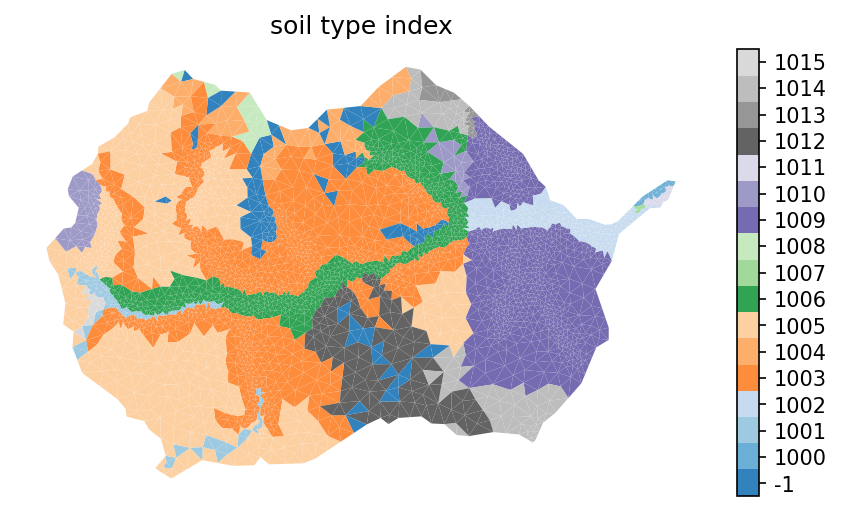

In [59]:
# create a new soil_color, keeping on those that are kept here and re-indexing to ATS indices
soil_color_new = -np.ones_like(soil_color)
for new_id, mukeys in enumerate(soil_survey_props_clean['native_index']):
    for mukey in mukeys:
        soil_color_new[np.where(soil_color == mukey)] = 1000+new_id

# # make sure no -1 in soil ids
# assert -1 not in np.unique(soil_color_new)
        
# image the new soil_color
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(soil_color_new, cmap='tab20c')
fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color_new, 
                        cmap=cmap, norm=norm)

watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color_new)), cmap=cmap, labels=labels) 

ax.set_title('soil type index')
ax.axis('off')

### GLHYMPS geologic layer

A copy of GLHYMPS v2 geologic shapefile has to be manually downloaded before running the following scripts (see source section for download instructions).

This will get properties (i.e., permeability and porosity) for each geologic layer. In case of missing data, default values of permeability (inf?) and porosity (0.01) will be used. Default van Genuchten alpha, n, and residual saturation are used due to lack of soil/silt/clay pct information. <span style="color:blue;"> </span>

In [60]:
# extract the GLYHMPS geologic structure data as shapes and project it onto the mesh
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))

_, geo_survey, geo_survey_props = \
    watershed_workflow.get_shapes(sources['geologic structure'], target_bounds, 
                                  crs, crs, properties=True)

# -- log the bounds targetted and found
logging.info('shape union bounds: {}'.format(
    shapely.ops.cascaded_union(geo_survey).bounds))

# -- determine the ID for each soil unit; this uniquely identifies formation
#    properties
geo_ids = np.array([shp.properties['id'] for shp in geo_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
geo_color_profile, geo_color_raster = \
            watershed_workflow.color_raster_from_shapes(geo_survey, crs, geo_ids,
                                                        target_bounds, 10, crs, -1)

# -- resample the raster to the triangles
geo_color = watershed_workflow.values_from_raster(m2.centroids, crs, 
                                         geo_color_raster, geo_color_profile)


2023-07-19 19:13:38,410 - root - INFO: target bounds: (317251.2640131897, 4299711.408984916, 328473.4449929282, 4307052.970983125)
2023-07-19 19:13:38,414 - root - INFO: 
2023-07-19 19:13:38,417 - root - INFO: Loading shapes
2023-07-19 19:13:38,420 - root - INFO: ------------------------------
2023-07-19 19:13:38,424 - root - INFO: Getting shapes of GLHYMPS on bounds: (317251.2640131897, 4299711.408984916, 328473.4449929282, 4307052.970983125)
2023-07-19 19:13:38,722 - root - INFO: ... found 17 shapes
2023-07-19 19:13:38,724 - root - INFO: Converting to shapely
2023-07-19 19:13:38,786 - root - INFO: Converting to requested CRS
2023-07-19 19:13:38,982 - root - INFO: shape union bounds: (309452.03384970897, 4277422.824854818, 338890.05886956863, 4329709.205645651)
2023-07-19 19:13:38,986 - root - INFO: Coloring shapes onto raster:
2023-07-19 19:13:38,995 - root - INFO:   of shape: (735, 1124)
2023-07-19 19:13:38,998 - root - INFO:   and 17 independent colors


In [61]:
geo_color = geo_color.astype(int)
geo_survey_props.set_index('id', inplace=True)
geo_survey_props = geo_survey_props.loc[np.unique(geo_color), :]
geo_survey_props

source  permeability [m^2]  logk_stdev [-]  porosity [-]  \
id                                                                  
715639  GLHYMPS        6.309573e-16            2.50          0.19   
715707  GLHYMPS        1.000000e-13            2.00          0.22   
715766  GLHYMPS        3.162278e-13            1.80          0.09   
715779  GLHYMPS        1.000000e-13            2.00          0.22   
715796  GLHYMPS        6.309573e-16            2.50          0.19   
726604  GLHYMPS        6.309573e-16            2.50          0.19   
726608  GLHYMPS        6.309573e-16            2.50          0.19   
726639  GLHYMPS        3.162278e-13            1.80          0.09   
726642  GLHYMPS        1.000000e-13            2.00          0.22   
726664  GLHYMPS        1.000000e-13            2.00          0.22   
726667  GLHYMPS        3.162278e-13            1.80          0.09   
730801  GLHYMPS        3.019952e-11            1.61          0.01   

        van Genuchten alpha [Pa^-1]  van Genuchten n [-]  \
id                                                         
715639                     0.000025                  2.0   
715707                     0.000294                  2.0   
715766                     0.000817                  2.0   
715779                     0.000294                  2.0   
715796                     0.000025                  2.0   
726604                     0.000025                  2.0   
726608                     0.000025                  2.0   
726639                     0.000817                  2.0   
726642                     0.000294                  2.0   
726664                     0.000294                  2.0   
726667                     0.000817                  2.0   
730801                     0.023953                  2.0   

        residual saturation [-]  
id                               
715639                     0.01  
715707                     0.01  
715766                     0.01  
715779                     0.01  
715796                     0.01  
726604                     0.01  
726608                     0.01  
726639                     0.01  
726642                     0.01  
726664                     0.01  
726667                     0.01  
730801                     0.01

/opt/conda/envs/watershed_workflow/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0, 'cmap': <matplotlib.colors.ListedColormap object at 0x409c99a7a0>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x409c99a770>}
setting face color =  [730801 730801 726639 ... 726639 726639 726639]


(316690.15495, 329034.55405000004, 4299344.3309, 4307420.0490999995)

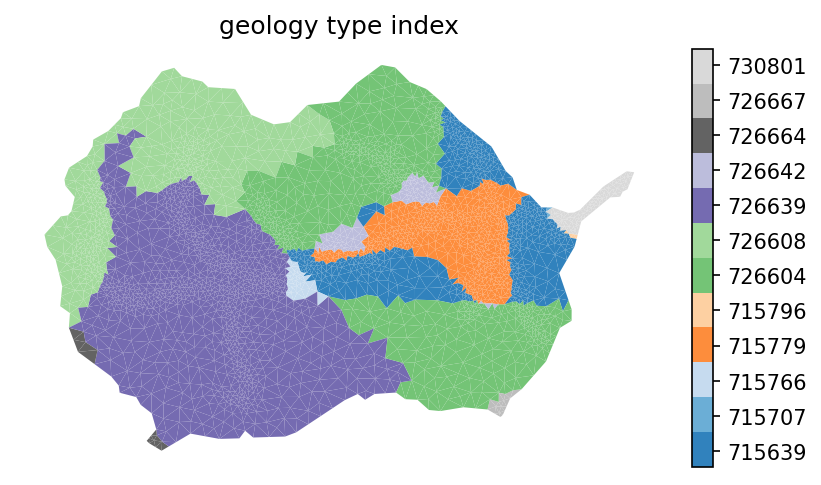

In [62]:
# plot the geologic formation id
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(geo_color, cmap = 'tab20c')


mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                                 linewidth=0, color=geo_color, cmap=cmap, norm=norm)

watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(geo_color)), cmap=cmap, labels = labels) 

ax.set_title('geology type index')
ax.axis('off')

min = -15.2, max = -10.52


(316690.15495, 329034.55405000004, 4299344.3309, 4307420.0490999995)

<Figure size 1800x900 with 0 Axes>

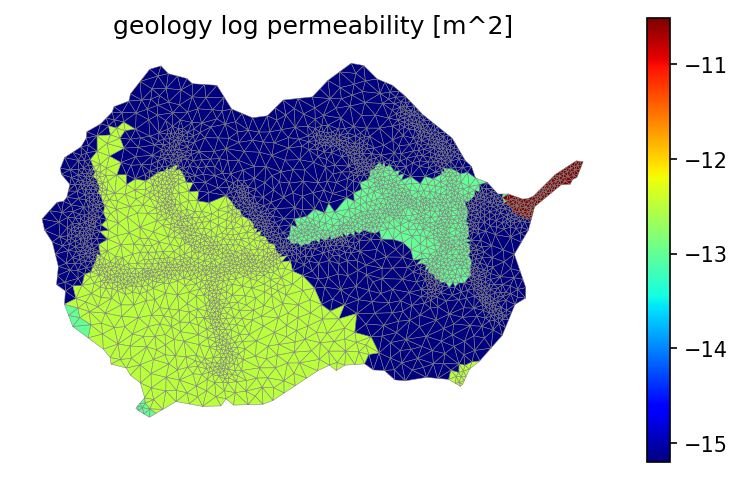

In [63]:
# averaging permeability is a tricky beast.  we average in log space, check that unit conversions make sense
fig = plt.figure(figsize=(12,6))
geol_perm = np.empty(geo_color.shape, 'd')
# soil_perm_rosetta = np.empty(soil_color.shape, 'd')

for i in geo_survey_props.index:
    geol_perm[geo_color == i] = geo_survey_props.loc[i, 'permeability [m^2]']
#     soil_perm_rosetta[soil_color == mukey] = soil_survey_props.loc[soil_survey_props['mukey'] == mukey, 'Rosetta permeability [m^2]']

pmin = min(np.nanmin(np.log10(geol_perm)), np.nanmin(np.log10(geol_perm)))
pmax = max(np.nanmax(np.log10(geol_perm)), np.nanmax(np.log10(geol_perm)))

  
print(f'min = {pmin}, max = {pmax}')
fig, ax = watershed_workflow.plot.get_ax(crs)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=np.log10(geol_perm), edgecolor='gray', cmap='jet',
                                vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp, shrink=0.8)
ax.set_title('geology log permeability [m^2]')
ax.axis('off')

In [64]:
# note there are clearly some common regions -- no need to duplicate those with identical values.
geo_survey_props = geo_survey_props.reset_index()
geo_survey_props_clean = geo_survey_props.copy()
geo_survey_props_clean.pop('logk_stdev [-]')
geo_survey_props_clean.rename(columns={'id':'native_index'}, inplace=True)

# remove duplicates
reindex_remove_duplicates(geo_survey_props_clean, 'native_index')
# assert geo_survey_props_clean['porosity [-]'][:].min() >= min_porosity
# assert geo_survey_props_clean['permeability [m^2]'][:].max() <= max_permeability
# assert geo_survey_props_clean['van Genuchten alpha [Pa^-1]'][:].max() <= max_vg_alpha

geo_survey_props_clean

native_index   source  permeability [m^2]  \
0  (715639, 715796, 726604, 726608)  GLHYMPS        6.309573e-16   
1  (715707, 715779, 726642, 726664)  GLHYMPS        1.000000e-13   
2          (715766, 726639, 726667)  GLHYMPS        3.162278e-13   
3                         (730801,)  GLHYMPS        3.019952e-11   

   porosity [-]  van Genuchten alpha [Pa^-1]  van Genuchten n [-]  \
0          0.19                     0.000025                  2.0   
1          0.22                     0.000294                  2.0   
2          0.09                     0.000817                  2.0   
3          0.01                     0.023953                  2.0   

   residual saturation [-]  
0                     0.01  
1                     0.01  
2                     0.01  
3                     0.01

/opt/conda/envs/watershed_workflow/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0, 'cmap': <matplotlib.colors.ListedColormap object at 0x4095fc4430>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x4095fc70d0>}
setting face color =  [103 103 102 ... 102 102 102]


(316690.15495, 329034.55405000004, 4299344.3309, 4307420.0490999995)

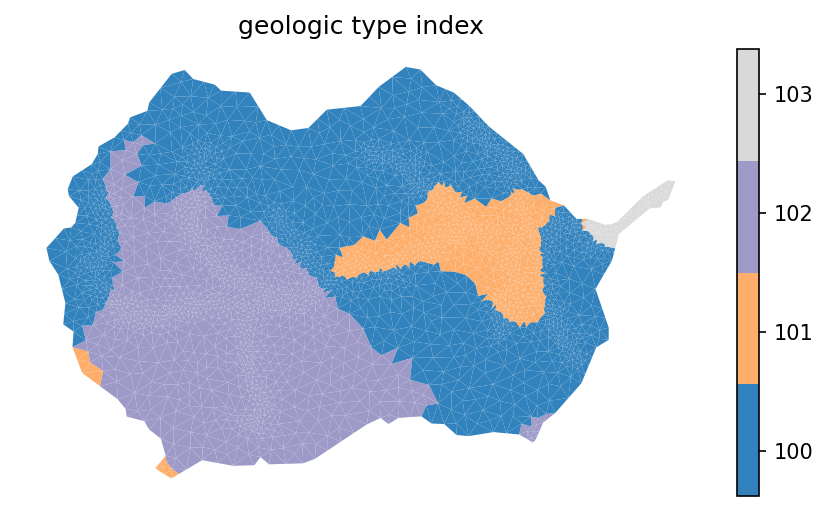

In [65]:
# create a new geologic layer color, keeping on those that are kept here and re-indexing to ATS indices
geo_color_new = -np.ones_like(geo_color)
for new_id, old_id_dups in enumerate(geo_survey_props_clean['native_index']):
    for old_id in old_id_dups:
        geo_color_new[np.where(geo_color == old_id)] = 100+ new_id
    
# image the new geo_color
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(geo_color_new, cmap='tab20c')
fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=geo_color_new, 
                        cmap=cmap, norm=norm)

watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(geo_color_new)), cmap=cmap, labels=labels) 

ax.set_title('geologic type index')
ax.axis('off')

## Depth-to-bedrock

Depth to bedrock is taken from the [SoilGrids](http://globalchange.bnu.edu.cn/research/dtb.jsp) product.  Here we download a US-based, clipped version of this global product, as file sizes are quite large (all products potentially used total over 100GB).

In [66]:
DTB_profile, DTB_raster = watershed_workflow.get_raster_on_shape(sources['depth to bedrock'], 
                                                                 watershed.exterior(), crs, 
                                                                 nodata=-99999)
                                        #, variable='BDTICM') # note, this argument needed for 
                                        # using the default SoilGrids dataset.

# resample the raster to the triangles
DTB_raster = DTB_raster/100 #convert from cm to m
DTB = watershed_workflow.values_from_raster(m2.centroids, crs, DTB_raster, DTB_profile, algorithm='piecewise bilinear')
DTB = np.where(DTB >= 0, DTB, np.nan)

2023-07-19 19:13:58,619 - root - INFO: 
2023-07-19 19:13:58,623 - root - INFO: Loading Raster
2023-07-19 19:13:58,626 - root - INFO: ------------------------------
2023-07-19 19:13:58,638 - root - INFO: Collecting raster
2023-07-19 19:13:58,717 - root - INFO: bounds in my_crs: (-107.10634327399998, 38.82770288200003, -106.97736783099998, 38.89466788700003)
2023-07-19 19:13:58,724 - root - INFO: ... got raster of shape: (33, 63)
2023-07-19 19:13:58,736 - root - INFO: ... got raster bounds: (-107.10834499599999, 38.895007756000005, -106.97709501699998, 38.82625776700001)


(316690.15495, 329034.55405000004, 4299344.3309, 4307420.0490999995)

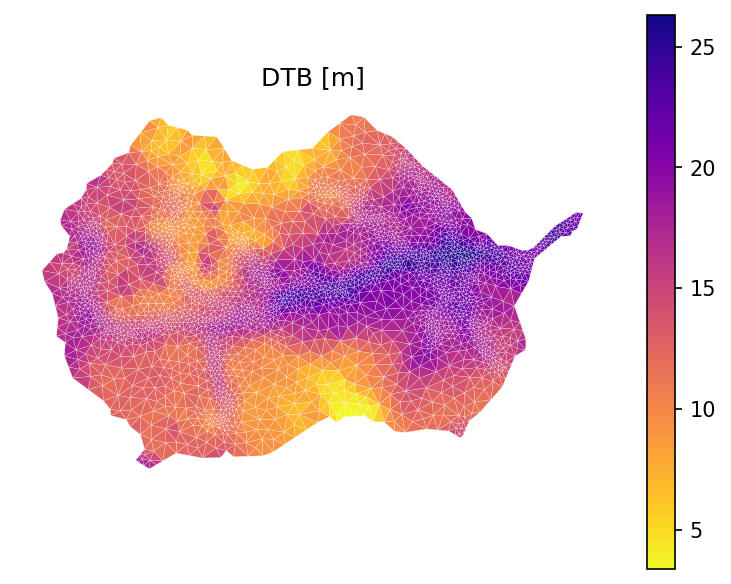

In [67]:
# plot the resulting surface mesh
fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=DTB, cmap='plasma_r', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp)
title = ax.set_title('DTB [m]')
ax.axis('off')


## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

First, all integer IDs in Exodus files must be unique.  This includes Material IDs, side sets, etc.  We create the Material ID map and data frame.  This is used to standardize IDs from multiple data sources.  Traditionally, ATS numbers Material IDs/Side Sets as:

* 0-9 : reserved for boundaries, surface/bottom, etc
* 10-99 : Land Cover side sets, typically NLCD IDs are used
* 100-999 : geologic layer material IDs
* 1000-9999 : soil layer material IDs




In [68]:
# map SSURGO mukey to ATS_ID
soil_survey_props_clean['ats_id'] = range(1000, 1000+len(soil_survey_props_clean))
soil_survey_props_clean.set_index('ats_id', inplace=True)

# map GLHYMPS id to ATS_ID
geo_survey_props_clean['ats_id'] = range(100, 100+len(geo_survey_props_clean))
geo_survey_props_clean.set_index('ats_id', inplace=True)

In [69]:
bedrock_props = watershed_workflow.soil_properties.get_bedrock_properties()
bedrock_props['source'] = 'SoilGrids'
bedrock_props['native_index'] = '(999,)'

In [70]:
# merge the properties databases
subsurface_props = pandas.concat([geo_survey_props_clean,
                                  soil_survey_props_clean,
                                  bedrock_props])
subsurface_props

native_index     source  permeability [m^2]  \
ats_id                                                                    
100     (715639, 715796, 726604, 726608)    GLHYMPS        6.309573e-16   
101     (715707, 715779, 726642, 726664)    GLHYMPS        1.000000e-13   
102             (715766, 726639, 726667)    GLHYMPS        3.162278e-13   
103                            (730801,)    GLHYMPS        3.019952e-11   
1000                           (509733,)       NRCS        2.279759e-13   
1001                           (509477,)       NRCS        2.734080e-12   
1002                    (498205, 498206)       NRCS        1.184189e-12   
1003                           (509548,)       NRCS        7.331979e-13   
1004                           (509529,)       NRCS        3.039095e-12   
1005                           (509532,)       NRCS        3.172415e-12   
1006                           (509482,)       NRCS        4.654687e-12   
1007                           (498208,)       NRCS        9.122162e-13   
1008                           (509559,)       NRCS        2.375523e-13   
1009                           (498231,)       NRCS        5.850942e-12   
1010                           (509513,)       NRCS        1.526682e-12   
1011                           (509794,)       NRCS        2.006536e-12   
1012                    (509479, 509481)       NRCS        7.504374e-13   
1013                           (498185,)       NRCS        1.590777e-13   
1014                           (509514,)       NRCS        5.262229e-12   
1015                           (509561,)       NRCS        1.554090e-12   
999                               (999,)  SoilGrids        1.000000e-16   

        porosity [-]  van Genuchten alpha [Pa^-1]  van Genuchten n [-]  \
ats_id                                                                   
100         0.190000                     0.000025             2.000000   
101         0.220000                     0.000294             2.000000   
102         0.090000                     0.000817             2.000000   
103         0.010000                     0.023953             2.000000   
1000        0.265563                     0.000092             1.319916   
1001        0.159737                     0.000139             1.457559   
1002        0.185986                     0.000071             1.420938   
1003        0.403218                     0.000059             1.416784   
1004        0.428779                     0.000103             1.383180   
1005        0.378365                     0.000079             1.374540   
1006        0.369886                     0.000092             1.397760   
1007        0.237423                     0.000072             1.395746   
1008        0.271630                     0.000079             1.340429   
1009        0.356163                     0.000157             1.406091   
1010        0.182238                     0.000087             1.422578   
1011        0.193350                     0.000104             1.433685   
1012        0.151250                     0.000078             1.410010   
1013        0.218625                     0.000081             1.332817   
1014        0.449752                     0.000221             1.762072   
1015        0.415245                     0.000140             1.367408   
999         0.050000                     0.000019             3.000000   

        residual saturation [-]  thickness [m]  
ats_id                                          
100                    0.010000            NaN  
101                    0.010000            NaN  
102                    0.010000            NaN  
103                    0.010000            NaN  
1000                   0.240269       1.520000  
1001                   0.181598       1.520000  
1002                   0.208316       1.520000  
1003                   0.213285       1.070000  
1004                   0.175133       1.520000  
1005                   0.230885       1.250000  
1006       

In [71]:
# save the properties to disk for use in generating input file
config['subsurface_properties_filename'] = os.path.join('..', '..', 'data', 'examples',watershed_name, 'processed', 'watershed_subsurface_properties.csv')
subsurface_props.to_csv(config['subsurface_properties_filename'])

Next we extrude the DEM to create a 3D mesh.

The most difficult aspect of extrusion is creating meshes that:
1. aren't huge numbers of cells
2. aren't huge cell thicknesses, especially near the surface
3. follow implied interfaces, e.g. bottom of soil and bottom of geologic layer

This is an iterative process that requires some care and some art.

In [72]:
# here we choose the bottom of the domain to be the maximum of the depth to bedrock.  
# This is really up to the user, but we are hard-coding this for this watershed_workflow.
total_thickness = np.ceil(DTB.max())
logging.info(f'max DTB: {total_thickness} m')

2023-07-19 19:14:01,910 - root - INFO: max DTB: 27.0 m


In [73]:
# Generate a dz structure for the top 2m of soil -- it appears from above that the soil thickness is uniformly 2m
#
# here we try for 10 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2m thick soil
dzs, res = watershed_workflow.mesh.optimize_dzs(0.05, 0.5, 2, 10)
print(dzs)

[0.05723957 0.07235405 0.10008891 0.1503918  0.24391084 0.37797867
 0.49803617 0.5       ]


In [74]:
# this looks like it would work out:
dzs_soil = [0.05, 0.05, 0.05, 0.12, 0.23, 0.5, 0.5, 0.5]

In [75]:
# a 2 m soil thickness and a maximum of 27 m depth to bedrock suggests a
# geologic layer of 13 * 2 m cells or something finer
dzs_geo = [2.0]*13

In [ ]:
assert np.sum(dzs_soil) + np.sum(dzs_geo) > total_thickness, "The sum of soil and geology layers should be greater than the total thickness!"

In [76]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- soil layer --
depth = 0
for dz in dzs_soil:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    br_or_geo = np.where(depth < DTB, geo_color_new, 999)
    soil_or_br_or_geo = np.where(np.bitwise_and(soil_color_new > 0, depth < soil_thickness),
                                 soil_color_new,
                                 br_or_geo)
    
    layer_mat_ids.append(soil_or_br_or_geo)
    depth += 0.5 * dz
    
# -- geologic layer --
for dz in dzs_geo:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(np.where(depth < DTB, geo_color_new, 999))
    depth += 0.5 * dz

# print the summary
watershed_workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2023-07-19 19:14:03,660 - root - INFO: Cell summary:
2023-07-19 19:14:03,662 - root - INFO: ------------------------------------------------------------
2023-07-19 19:14:03,666 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2023-07-19 19:14:03,669 - root - INFO: ------------------------------------------------------------
2023-07-19 19:14:03,672 - root - INFO:  00 	| 00 	| 1000 	|   0.050000 	|   0.000000
2023-07-19 19:14:03,676 - root - INFO:  01 	| 01 	| 1000 	|   0.050000 	|   0.050000
2023-07-19 19:14:03,679 - root - INFO:  02 	| 02 	| 1000 	|   0.050000 	|   0.100000
2023-07-19 19:14:03,686 - root - INFO:  03 	| 03 	| 1000 	|   0.120000 	|   0.150000
2023-07-19 19:14:03,690 - root - INFO:  04 	| 04 	| 1000 	|   0.230000 	|   0.270000
2023-07-19 19:14:03,693 - root - INFO:  05 	| 05 	| 1000 	|   0.500000 	|   0.500000
2023-07-19 19:14:03,698 - root - INFO:  06 	| 06 	|  103 	|   0.500000 	|   1.000000
2023-07-19 19:14:03,700 - root - INFO:  07 	| 07 	|  103 	|   0.500000 	|   1.5

In [77]:
# extrude
m3 = watershed_workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

In [78]:
# # add back on land cover side sets
# surf_ss = m3.side_sets[1]

# for index, name in zip(nlcd_indices, nlcd_labels):
#     where = np.where(lc == index)[0]
#     ss = watershed_workflow.mesh.SideSet(name, int(index), 
#                             [surf_ss.cell_list[w] for w in where],
#                             [surf_ss.side_list[w] for w in where])        
#     m3.side_sets.append(ss)

In [79]:
print(f'total number of cells: {m3.num_cells}')
print('---------------')
print('2D labeled sets')
print('---------------')
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

print('')
print('Extruded 3D labeled sets')
print('------------------------')
ls = {}
for i in m3.labeled_sets:
    ls[i.name] = {'setid':i.setid, 'entity':i.entity}
    print(f'{i.setid} : {i.entity} : {len(i.ent_ids)} : "{i.name}"')

print('')
print('Extruded 3D side sets')
print('---------------------')
ss = {}
for i in m3.side_sets:
    ss[i.name] = {'setid':i.setid}
    print(f'{i.setid} : FACE : {len(i.cell_list)} : "{i.name}"')

total number of cells: 117810
---------------
2D labeled sets
---------------
10000 : CELL : 5610 : "140200010204"
10001 : CELL : 5610 : "140200010204 surface"
10002 : FACE : 182 : "140200010204 boundary"
10003 : FACE : 12 : "140200010204 outlet"
10004 : FACE : 12 : "surface domain outlet"
8 : CELL : 3449 : "MODIS Woody Savannas"
9 : CELL : 148 : "MODIS Savannas"
10 : CELL : 2013 : "MODIS Grasslands"

Extruded 3D labeled sets
------------------------
10000 : CELL : 117810 : "140200010204"

Extruded 3D side sets
---------------------
1 : FACE : 5610 : "bottom"
2 : FACE : 5610 : "surface"
3 : FACE : 3822 : "external_sides"
10001 : FACE : 5610 : "140200010204 surface"
10002 : FACE : 3822 : "140200010204 boundary"
10003 : FACE : 252 : "140200010204 outlet"
10004 : FACE : 252 : "surface domain outlet"
8 : FACE : 3449 : "MODIS Woody Savannas"
9 : FACE : 148 : "MODIS Savannas"
10 : FACE : 2013 : "MODIS Grasslands"


In [80]:
config['labeled_sets'] = ls
config['side_sets'] = ss

### Save mesh file

This will write the 3D mesh to ExodusII using arbitrary polyhedra specification. 

In [81]:
config['mesh_filename'] = os.path.join('..', '..', 'data', 'examples',watershed_name, 'processed','watershed_mesh.exo')

try:
    os.remove(config['mesh_filename'])
except FileNotFoundError:
    pass
m3.write_exodus(config['mesh_filename'])


You are using exodus.py v 1.20.10 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: ../../data/examples/CoalCreek/processed/watershed_mesh.exo


2023-07-19 19:15:40,272 - root - INFO: adding side set: 1
2023-07-19 19:15:44,048 - root - INFO: adding side set: 2
2023-07-19 19:15:48,152 - root - INFO: adding side set: 3
2023-07-19 19:15:51,894 - root - INFO: adding side set: 10001
2023-07-19 19:15:56,183 - root - INFO: adding side set: 10002
2023-07-19 19:16:00,163 - root - INFO: adding side set: 10003
2023-07-19 19:16:03,759 - root - INFO: adding side set: 10004
2023-07-19 19:16:07,463 - root - INFO: adding side set: 8
2023-07-19 19:16:11,086 - root - INFO: adding side set: 9
2023-07-19 19:16:14,985 - root - INFO: adding side set: 10
2023-07-19 19:16:19,339 - root - INFO: adding elem set: 10000


Closing exodus file: ../../data/examples/CoalCreek/processed/watershed_mesh.exo


In [82]:
config['start_date'] = start_date
config['end_date'] = end_date
config['origin_date'] = origin_date

In [83]:
config

{'catchment_labels': ['140200010204'],
 'nlcd_indices': [8, 9, 10],
 'nlcd_labels': ['MODIS Woody Savannas', 'MODIS Savannas', 'MODIS Grasslands'],
 'LAI_filename': '../../data/examples/CoalCreek/processed/watershed_lai_raw.h5',
 'LAI_typical_filename': '../../data/examples/CoalCreek/processed/watershed_lai_typical.h5',
 'subsurface_properties_filename': '../../data/examples/CoalCreek/processed/watershed_subsurface_properties.csv',
 'labeled_sets': {'140200010204': {'setid': 10000, 'entity': 'CELL'}},
 'side_sets': {'bottom': {'setid': 1},
  'surface': {'setid': 2},
  'external_sides': {'setid': 3},
  '140200010204 surface': {'setid': 10001},
  '140200010204 boundary': {'setid': 10002},
  '140200010204 outlet': {'setid': 10003},
  'surface domain outlet': {'setid': 10004},
  'MODIS Woody Savannas': {'setid': 8},
  'MODIS Savannas': {'setid': 9},
  'MODIS Grasslands': {'setid': 10}},
 'mesh_filename': '../../data/examples/CoalCreek/processed/watershed_mesh.exo',
 'start_date': '2015-10-

In [84]:
# Save dictionary to a file
# config['config_file'] = os.path.join('..', '..', 'data', 'examples',watershed_name, 'processed','config.yaml')

with open(config_fname, 'w') as file:
    yaml.dump(config, file)